In [1]:
%config InlineBackend.figure_format = 'retina'
from micecat_auto import *

ra_min, ra_max = 40, 50
dec_min, dec_max = 0, 4
fname = 'ra%d_%d_dec%d_%d_full'%(ra_min, ra_max, dec_min, dec_max)
fname = mypaths['MCcatdat'] + fname + '.csv.bz2'
with bz2.BZ2File(fname) as catalog_fd:
    df = pd.read_csv(catalog_fd, sep=",", index_col=False,
                     comment='#', na_values=r'\N')

/Users/ytcheng/ciber/python_ciber/stack_modelfit/Helgason.py:87: RuntimeWarning: divide by zero encountered in log
  phi0 = np.log(self.LF_band(z, idx0, M_arr=M_arr)[1])
/Users/ytcheng/ciber/python_ciber/stack_modelfit/Helgason.py:90: RuntimeWarning: invalid value encountered in add
  phi_arr = phi0 + (wl_rf - wl0) * (phi1 - phi0) / (wl1 - wl0)


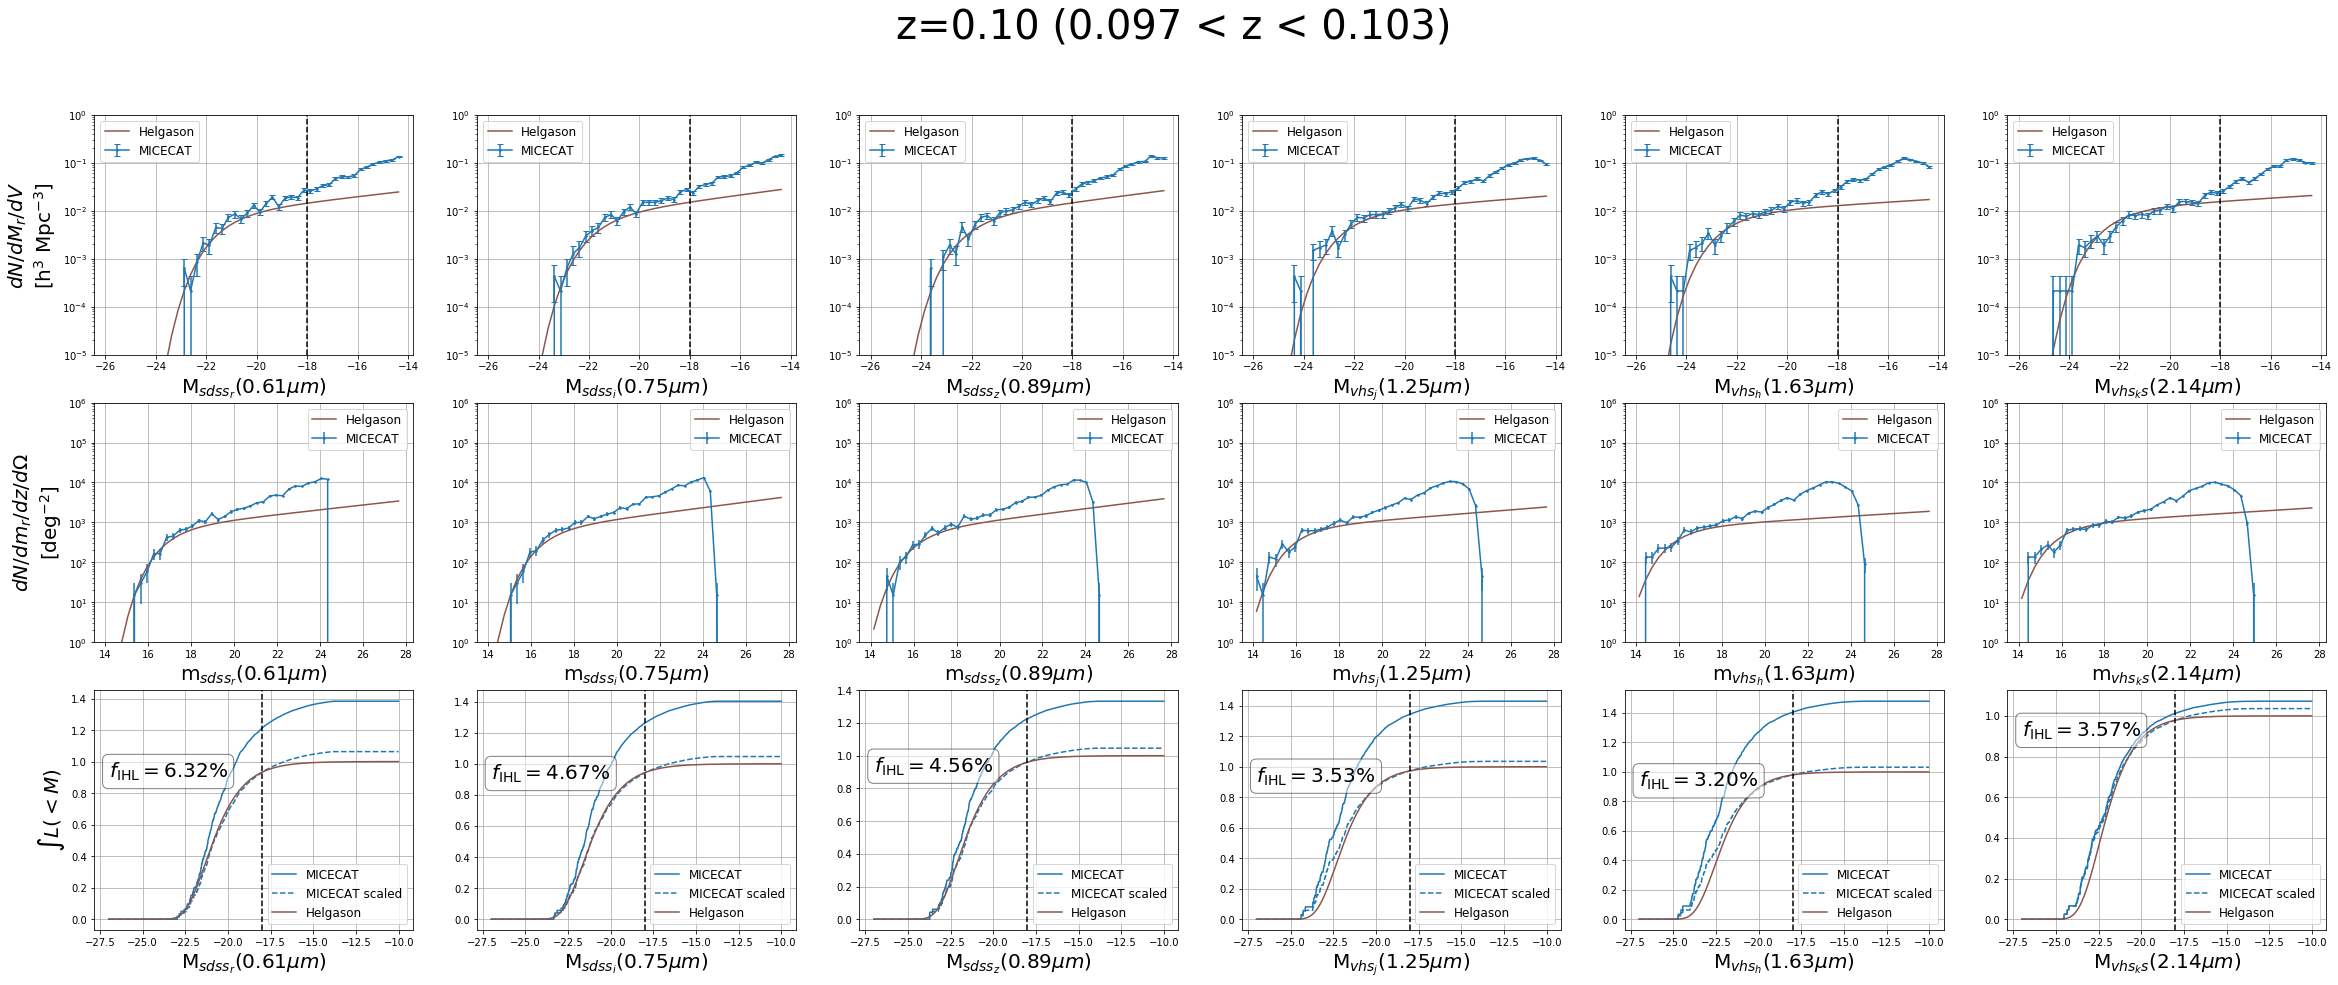

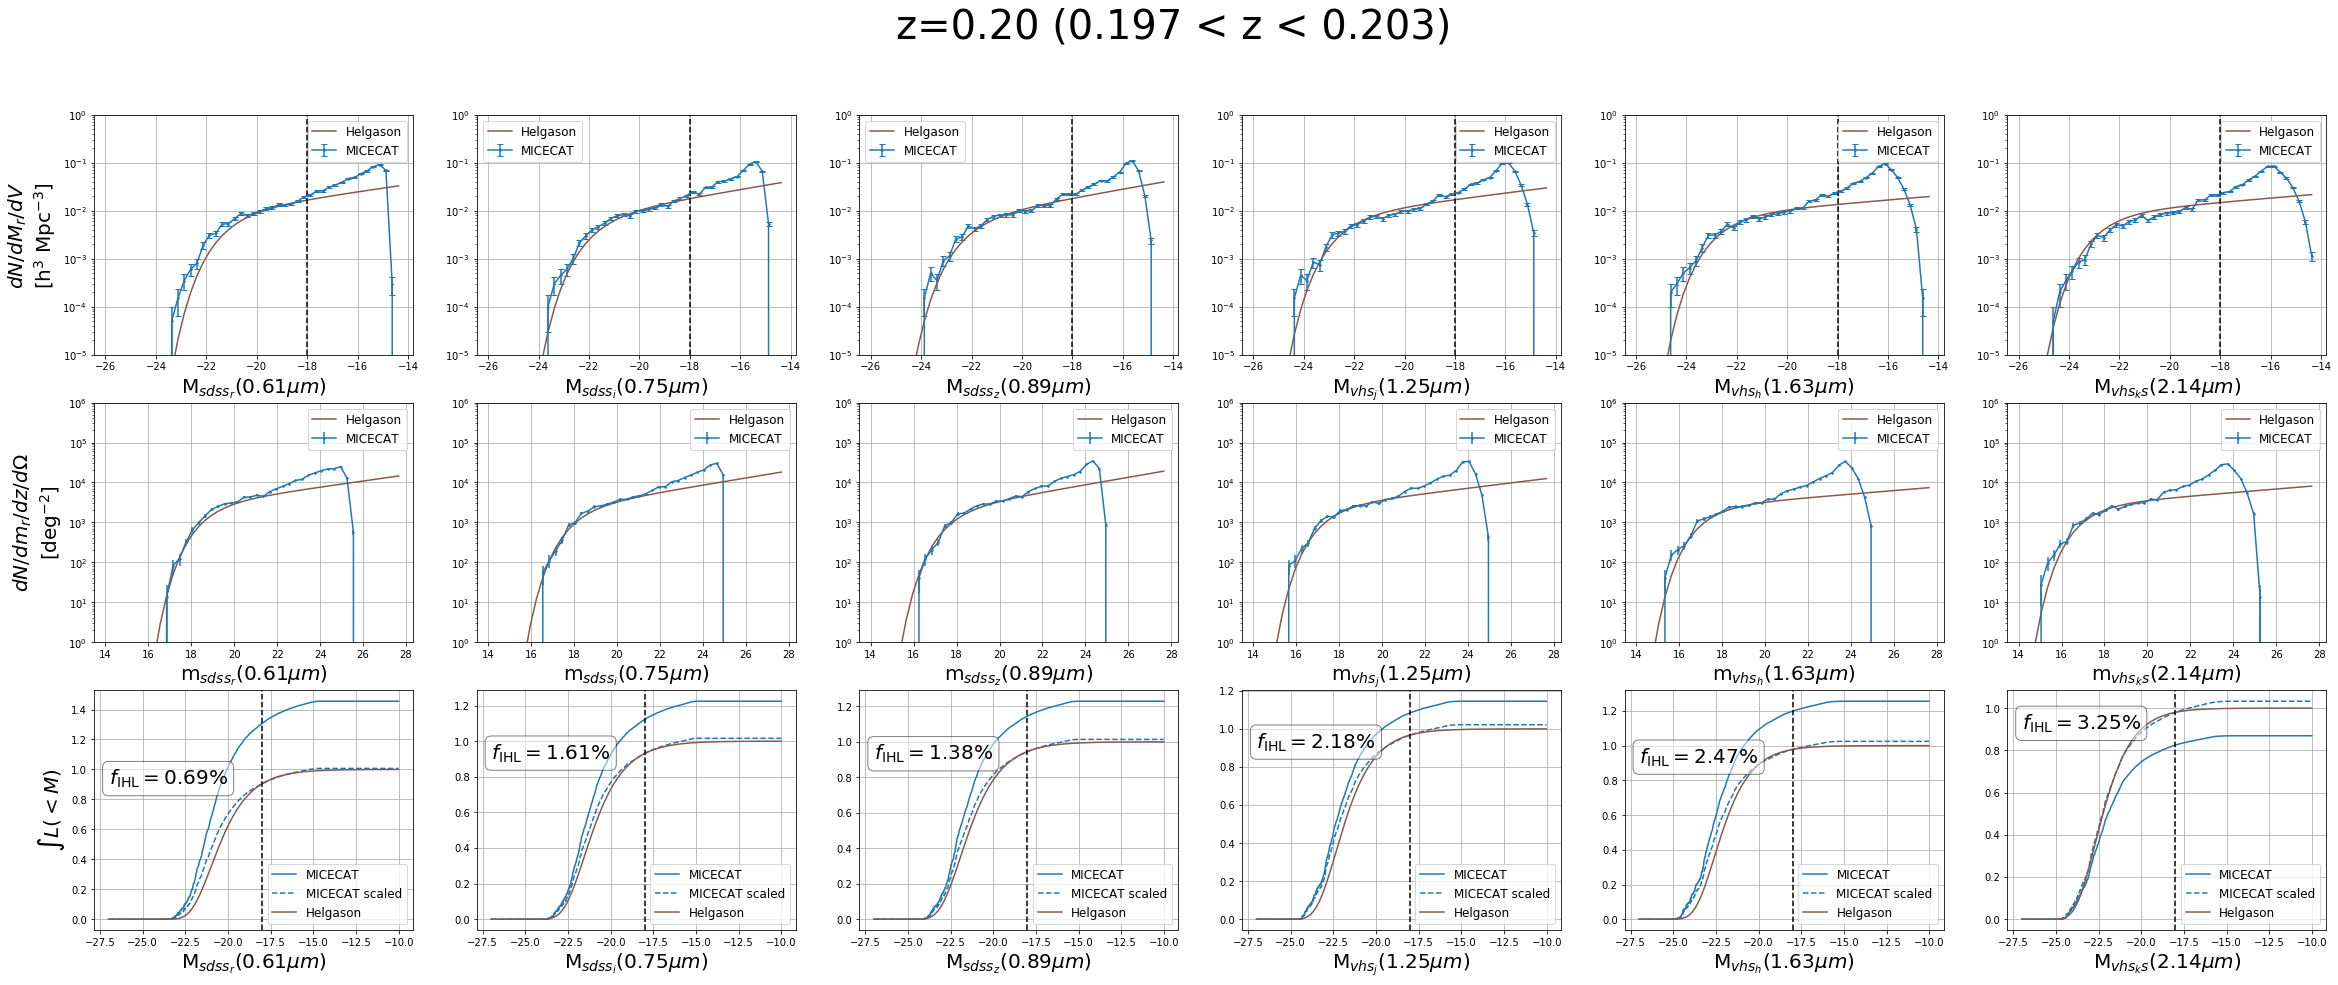

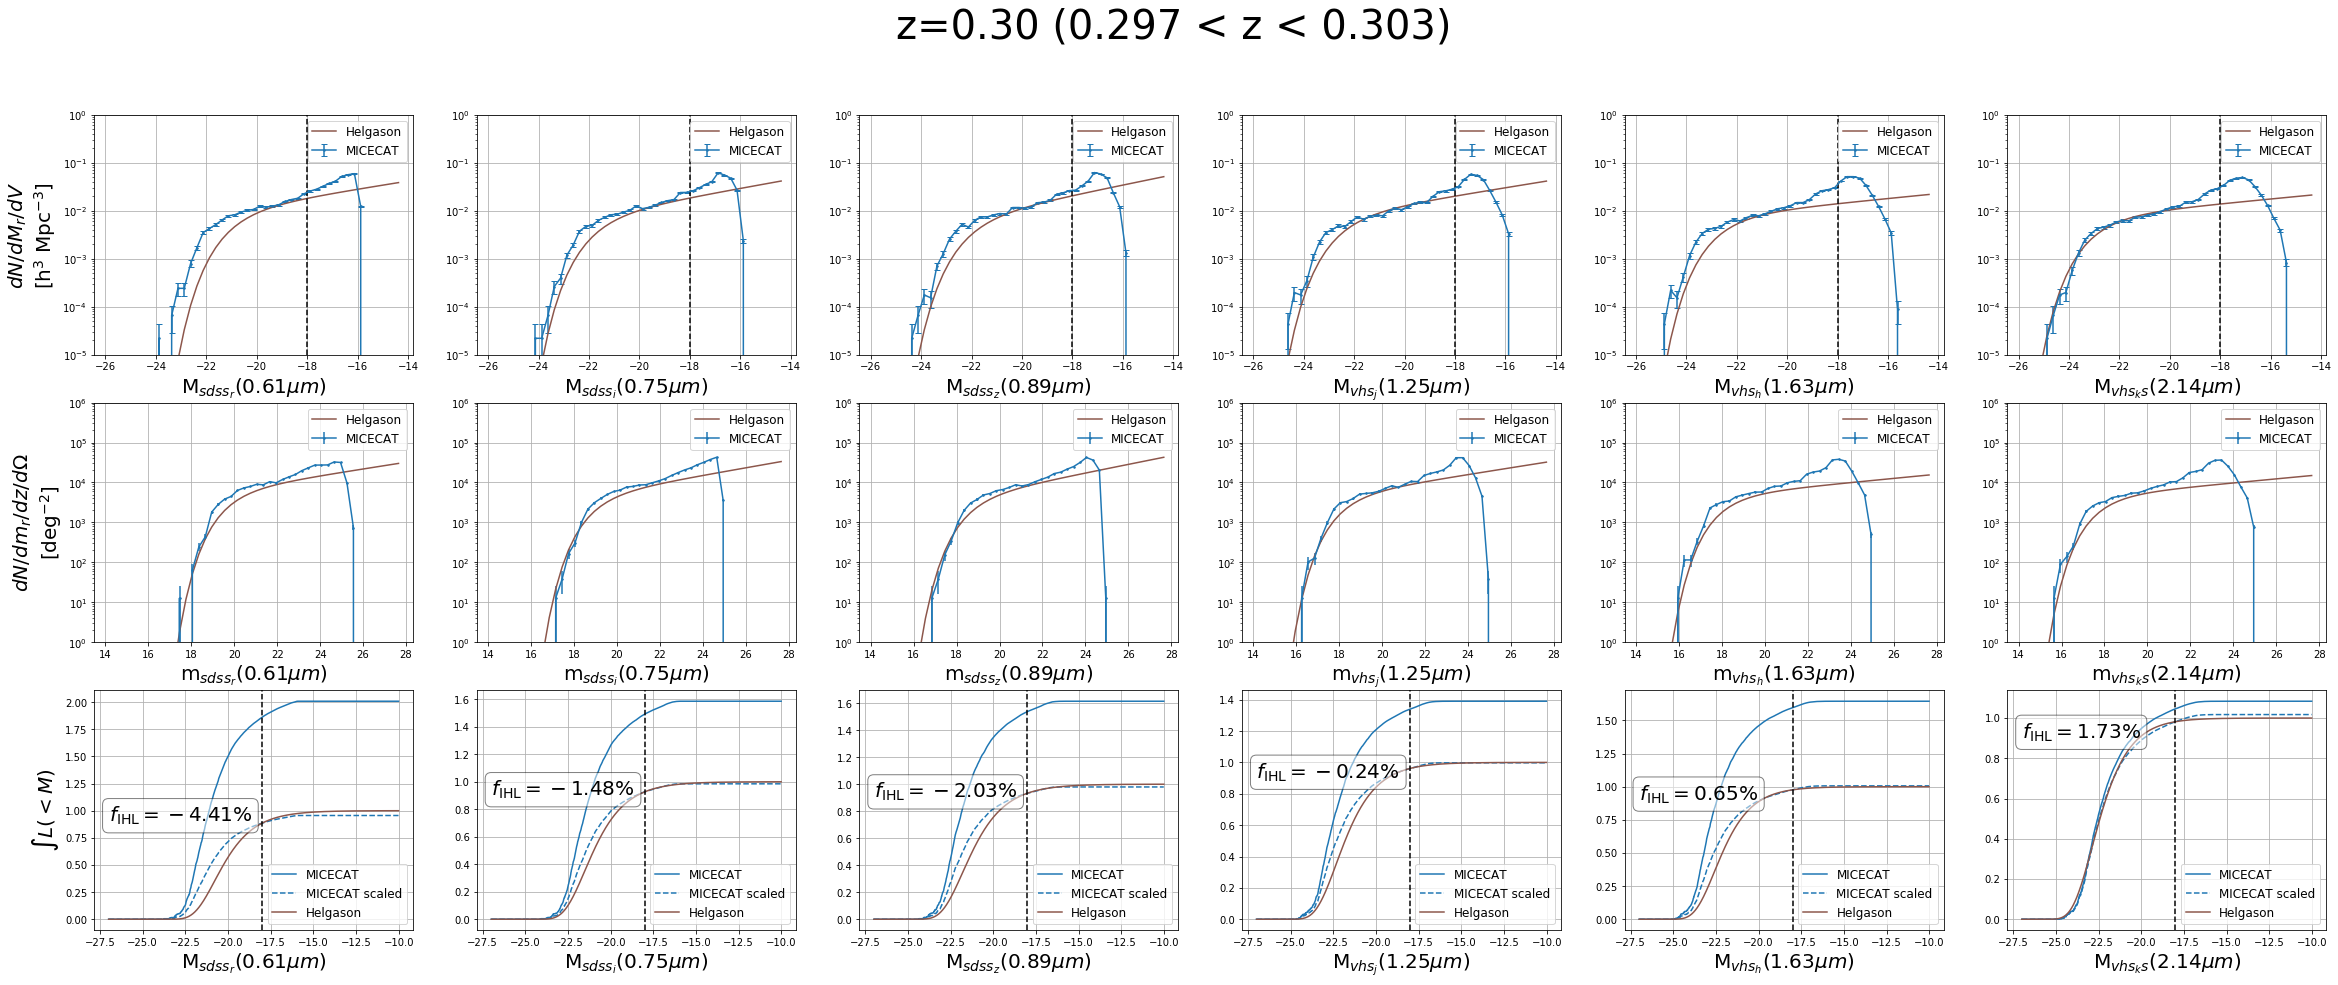

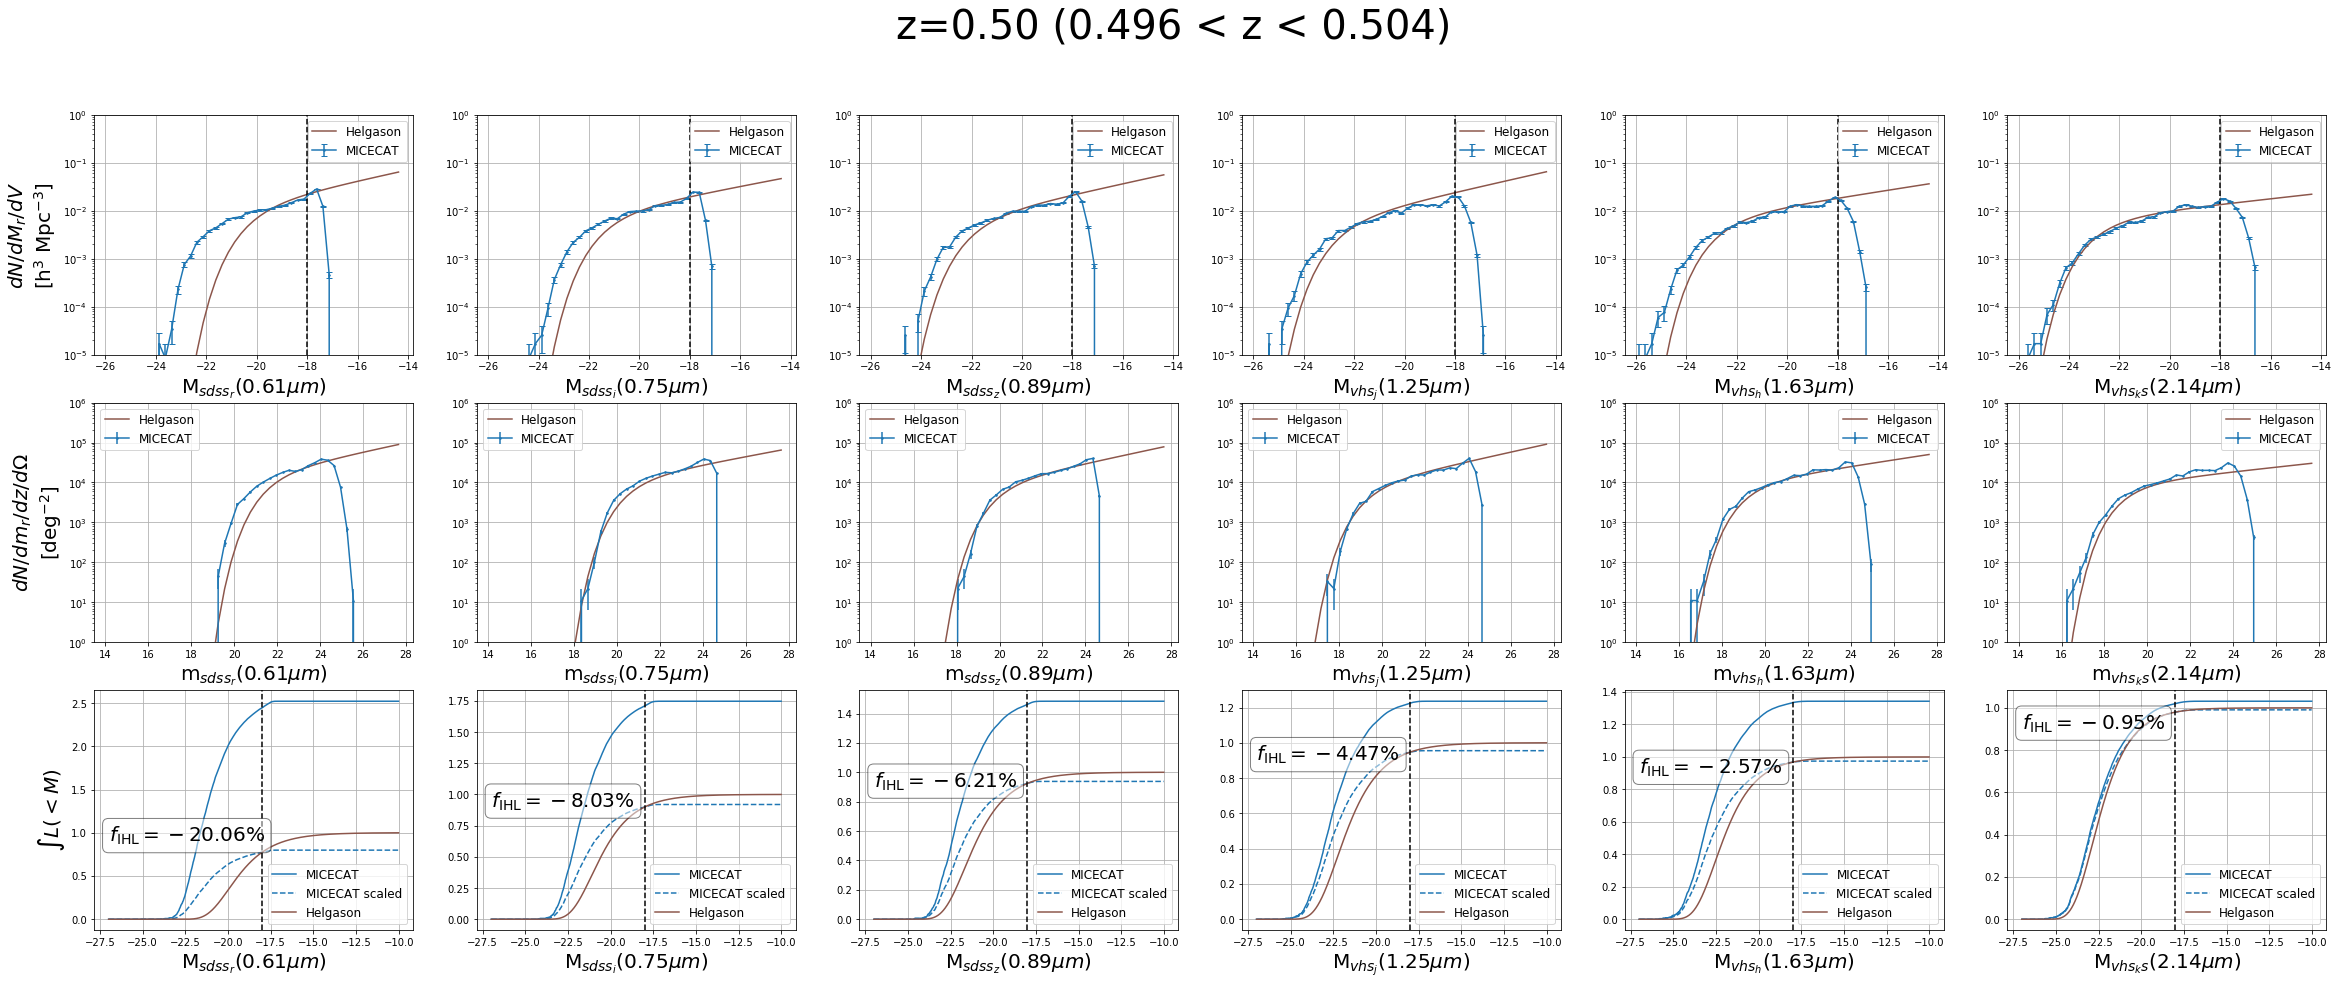

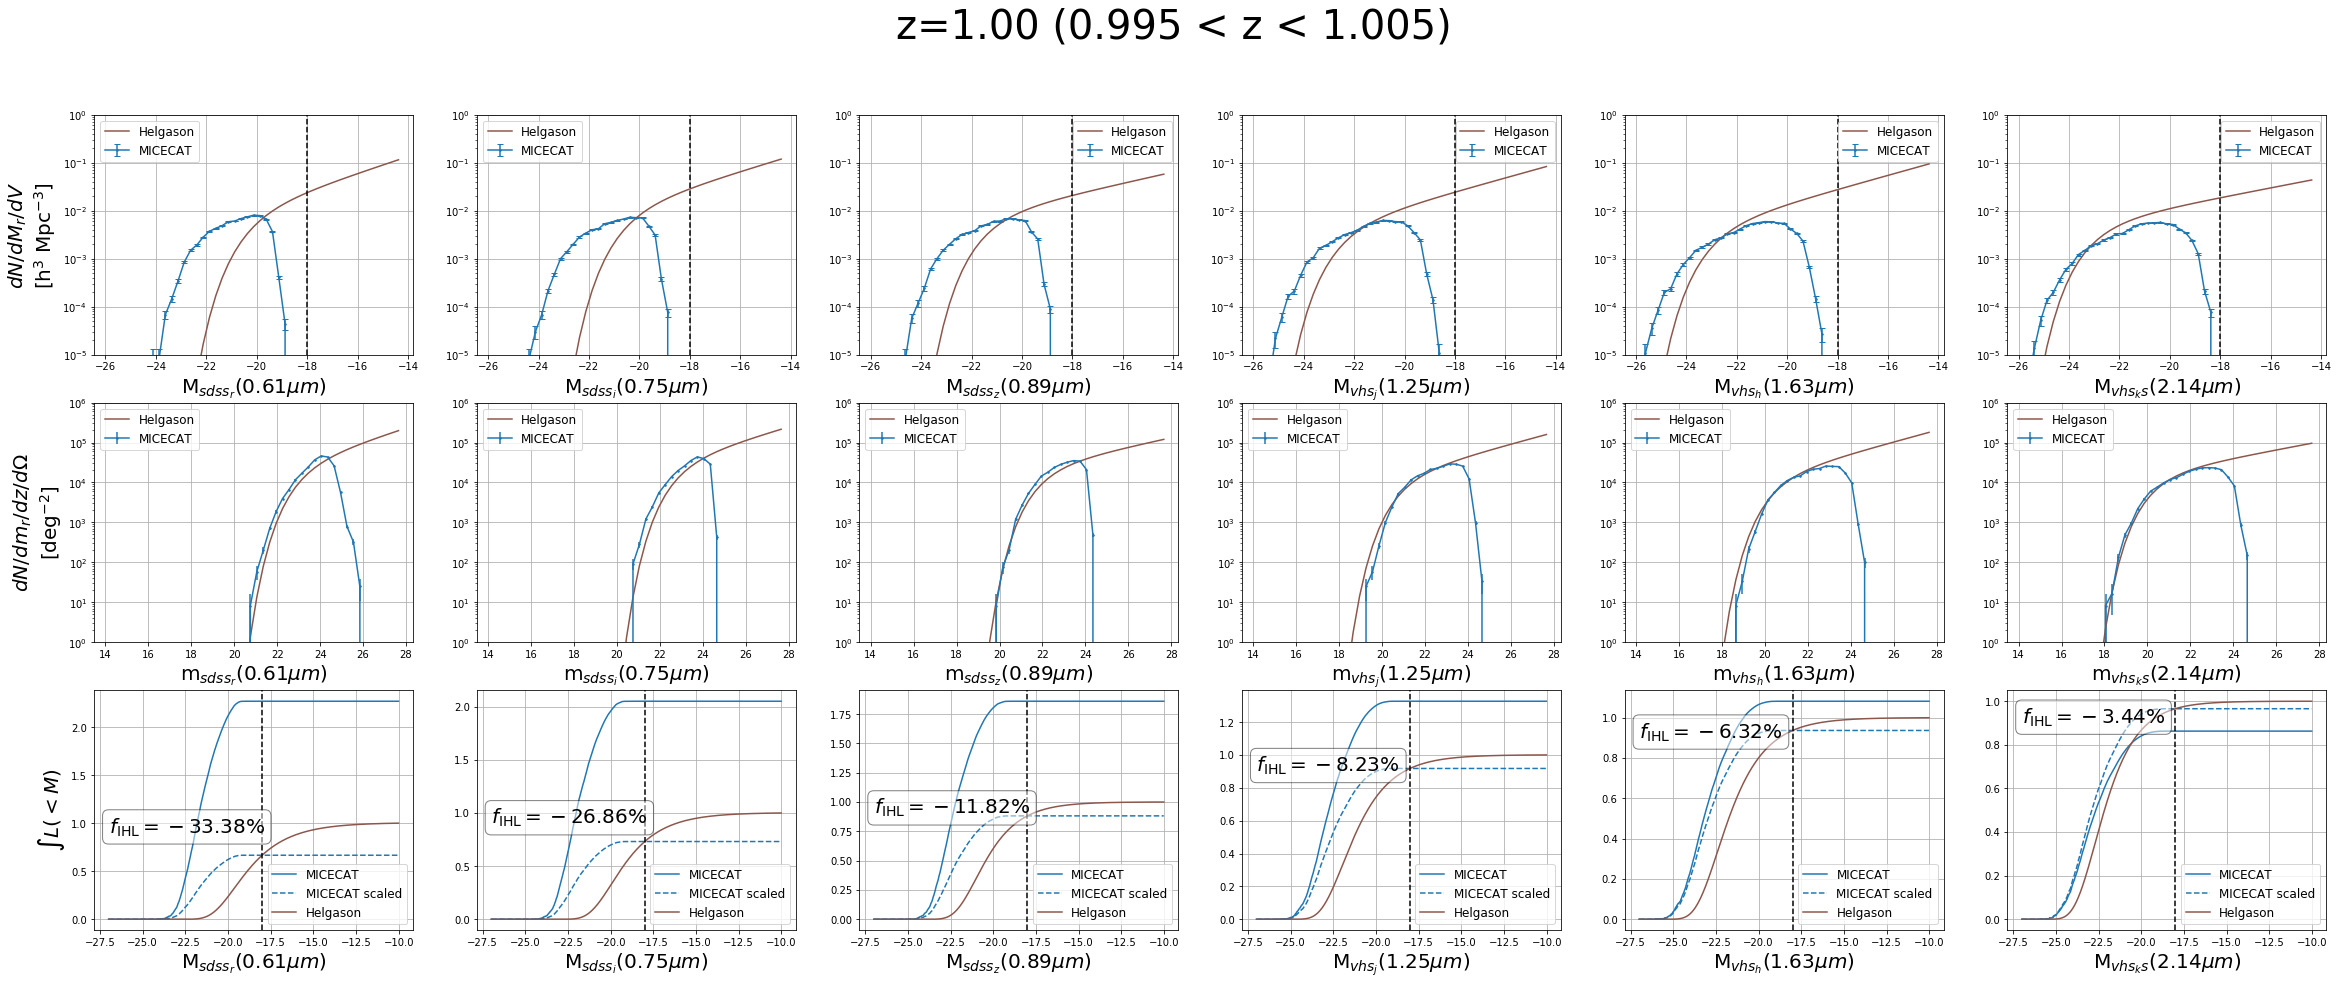

In [26]:
from Helgason import *

bandwl_dict = {'sdss_u':0.360804, 'sdss_g':0.467178, 'sdss_r':0.614112, 
               'sdss_i':0.745789, 'sdss_z':0.892278,
               'vhs_j':1.248100, 'vhs_h':1.634819, 'vhs_ks':2.143546}

Omega_cat = (ra_max - ra_min) * (dec_max - dec_min)

z_mid_arr = [0.1, 0.2, 0.3, 0.5, 1]
Mnorm_arr = [-18, -18, -18, -18, -18]
for z_mid,Mnorm in zip(z_mid_arr, Mnorm_arr):
    fig, ax = plt.subplots(3,6,figsize=(40,15))
    delz = 0.005
    Dz = (1 + z_mid) * delz
    z_min, z_max = z_mid - Dz/2, z_mid + Dz/2
    z_mid = (z_min + z_max) / 2
    dfi = df[(df.z_cgal<z_max) & (df.z_cgal>z_min)]

    # get cmv volume
    Vcmv = 0 # (Mpc/h)^3
    zbinedges = np.linspace(np.min(dfi.z_cgal), np.max(dfi.z_cgal),100)
    for _,(z1, z2) in enumerate(zip(zbinedges[:-1], zbinedges[1:])):
        dfiz = dfi[(dfi.z_cgal>=z1) & (dfi.z_cgal<z2)]
        x1, x2 = np.min(dfiz.xgal), np.max(dfiz.xgal)
        y1, y2 = np.min(dfiz.ygal), np.max(dfiz.ygal)
        dz = (cosmo.comoving_distance(z2)-cosmo.comoving_distance(z1)).value*0.7
        Vcmv += ((x2-x1) * (y2-y1) * (dz))

    for iband, band in enumerate(['sdss_r', 'sdss_i', 'sdss_z', 'vhs_j','vhs_h','vhs_ks']):
        bandwl = bandwl_dict[band]

        Mbinedges = np.arange(-26, -14, 0.25)#np.linspace(-24,-15,30)
        Mbins = (Mbinedges[1:] + Mbinedges[:-1]) / 2
        dM = Mbinedges[1] - Mbinedges[0]
        Lbins = 10**(-Mbins/2.5)
        
        M = dfi[band+'_abs_mag'].values - 0.8 * (np.arctan(1.5 * dfi.z_cgal.values) - 0.1489)
        M = M + 5*np.log10(0.7)
        phi_mc = np.histogram(M, bins=Mbinedges)[0]
        phi_mc_err = np.sqrt(phi_mc)
        phi_mc, phi_mc_err = phi_mc/dM/Vcmv, phi_mc_err/dM/Vcmv # (h/Mpc)^3
        ax[0][iband].errorbar(Mbins, phi_mc, phi_mc_err,capsize=3,
                              fmt='.-', markersize=3,label='MICECAT')

        phi_h = Helgason_model().LF_wl(z_mid, bandwl/(1+z_mid), Mbins)[1]/0.7**3# (h/Mpc)^3
        ax[0][iband].semilogy(Mbins, phi_h,'C5',label='Helgason')
        ax[0][iband].axvline(Mnorm, c='k', ls='--')
        ax[0][iband].grid()
        ax[0][iband].set_ylim([1e-5,1e0])
        ax[0][0].set_ylabel(r'$dN/dM_{r}/dV$' + '\n' +r'[h$^3$ Mpc$^{-3}$]',fontsize=20)
        ax[0][iband].set_xlabel(r'M$_{%s}(%.2f\mu m)$'%(band,bandwl), fontsize=20)
        ax[0][iband].legend(fontsize=12)

        # =================
        mbinedges = np.arange(14,28,0.3)
        mbins = (mbinedges[1:] + mbinedges[:-1])/2

        dfi = df[(df.z_cgal>=z_min) & (df.z_cgal<z_max)]
        m = dfi[band+'_true'].values - 0.8 * (np.arctan(1.5 * dfi.z_cgal.values) - 0.1489)
        dN_dm_ddeg2m = np.histogram(m, bins=mbinedges)[0]
        dN_dm_ddeg2m_err = np.sqrt(dN_dm_ddeg2m)
        dN_dm_ddeg2m = dN_dm_ddeg2m / np.diff(mbinedges) / Omega_cat / (z_max - z_min)
        dN_dm_ddeg2m_err = dN_dm_ddeg2m_err / np.diff(mbinedges) / Omega_cat / (z_max - z_min)
        ax[1][iband].errorbar(mbins, dN_dm_ddeg2m, dN_dm_ddeg2m_err, fmt='.-',
                              markersize=3,label='MICECAT')

        dN_dm_ddeg2h = [Helgason_model().dN_dsr(bandwl,zmin=z_min,zmax=z_max,m_min=m_min,m_max=m_max) \
                        for m_min, m_max in zip(mbinedges[:-1],mbinedges[1:])]
        dN_dm_ddeg2h = np.array(dN_dm_ddeg2h) / (z_max - z_min)
        dN_dm_ddeg2h = np.array(dN_dm_ddeg2h) / np.diff(mbinedges) / (u.sr).to(u.deg**2)
        ax[1][iband].semilogy(mbins, dN_dm_ddeg2h,'C5',label='Helgason')
        ax[1][iband].set_ylim([1e0, 1e6])
        ax[1][iband].grid()
        ax[1][0].set_ylabel(r'$dN/dm_{r}/dz/d\Omega$' + '\n' +r'[deg$^{-2}$]',fontsize=20)
        ax[1][iband].set_xlabel(r'm$_{%s}(%.2f\mu m)$'%(band,bandwl), fontsize=20)
        ax[1][iband].legend(fontsize=12)
        
        # =========
        Mbinedges = np.arange(-30, -10, 0.01)
        Mbins = (Mbinedges[1:] + Mbinedges[:-1]) / 2
        dM = Mbinedges[1] - Mbinedges[0]
        Lbins = 10**(-Mbins/2.5)
        
        M = dfi[band+'_abs_mag'].values - 0.8 * (np.arctan(1.5 * dfi.z_cgal.values) - 0.1489)
        M = M + 5*np.log10(0.7)
        phi_mc = np.histogram(M, bins=Mbinedges)[0]
        phi_mc = phi_mc/dM/Vcmv # (h/Mpc)^3
        Lcum = np.cumsum(phi_mc*dM*Lbins)
        Mbinedges = np.arange(-27, -10, 0.01)
        Mbins = (Mbinedges[1:] + Mbinedges[:-1]) / 2
        dM = Mbinedges[1] - Mbinedges[0]
        Lbins = 10**(-Mbins/2.5)

        M = dfi[band+'_abs_mag'].values - 0.8 * (np.arctan(1.5 * dfi.z_cgal.values) - 0.1489)
        M = M + 5*np.log10(0.7)
        phi_mc = np.histogram(M, bins=Mbinedges)[0]
        phi_mc = phi_mc/dM/Vcmv # (h/Mpc)^3
        Lcum_mc = np.cumsum(phi_mc*dM*Lbins)

        phi_h = Helgason_model().LF_wl(z_mid, bandwl/(1+z_mid), Mbins)[1]/0.7**3# (h/Mpc)^3
        Lcum_h = np.nancumsum(phi_h*dM*Lbins)

        idx_norm = np.argmin(np.abs(Mbins-Mnorm))
        Lcum_mc_norm = Lcum_mc * Lcum_h[idx_norm]/Lcum_mc[idx_norm]
        
        Lcum_mc /= Lcum_h[-1]
        Lcum_mc_norm /= Lcum_h[-1]
        Lcum_h /= Lcum_h[-1]
        f_IHL = (Lcum_mc_norm[-1]-Lcum_h[-1]) / Lcum_h[-1]
        ax[2][iband].plot(Mbins, Lcum_mc,'C0',label='MICECAT')
        ax[2][iband].plot(Mbins, Lcum_mc_norm,'C0--',label='MICECAT scaled')
        ax[2][iband].plot(Mbins, Lcum_h,'C5',label='Helgason')
        ax[2][iband].grid()
        ax[2][0].set_ylabel(r'$\int L(<M)$',fontsize=20)
        ax[2][iband].set_xlabel(r'M$_{%s}(%.2f\mu m)$'%(band,bandwl), fontsize=20)
        ax[2][iband].legend(fontsize=12)
        ax[2][iband].axvline(Mnorm, c='k', ls='--')
        ax[2][iband].text(-27,0.9,r'$f_{\rm IHL} = %.2f$%%'%(f_IHL*100),fontsize=20,
                      bbox={'boxstyle':'round','facecolor': 'white', 'alpha':0.5})
    fig.suptitle('z={:.2f} ({:.3f} < z < {:.3f})'.format(z_mid, z_min, z_max), fontsize=40)
    #     fig.savefig('plots/IHL/LF_SDSS_%s.pdf'%band, dpi = 100, bbox_inches='tight')

***

In [ ]:
# %config InlineBackend.figure_format = 'retina'
# from micecat_auto import *

# ra_min, ra_max = 40, 50
# dec_min, dec_max = 0, 4
# fname = 'ra%d_%d_dec%d_%d_full'%(ra_min, ra_max, dec_min, dec_max)
# fname = mypaths['MCcatdat'] + fname + '.csv.bz2'
# with bz2.BZ2File(fname) as catalog_fd:
#     df = pd.read_csv(catalog_fd, sep=",", index_col=False,
#                      comment='#', na_values=r'\N')

/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in true_divide


Text(0, 0.5, '$\\nu I_\\nu(<z)$ [nW m$^2$ sr$^{-1}$]')

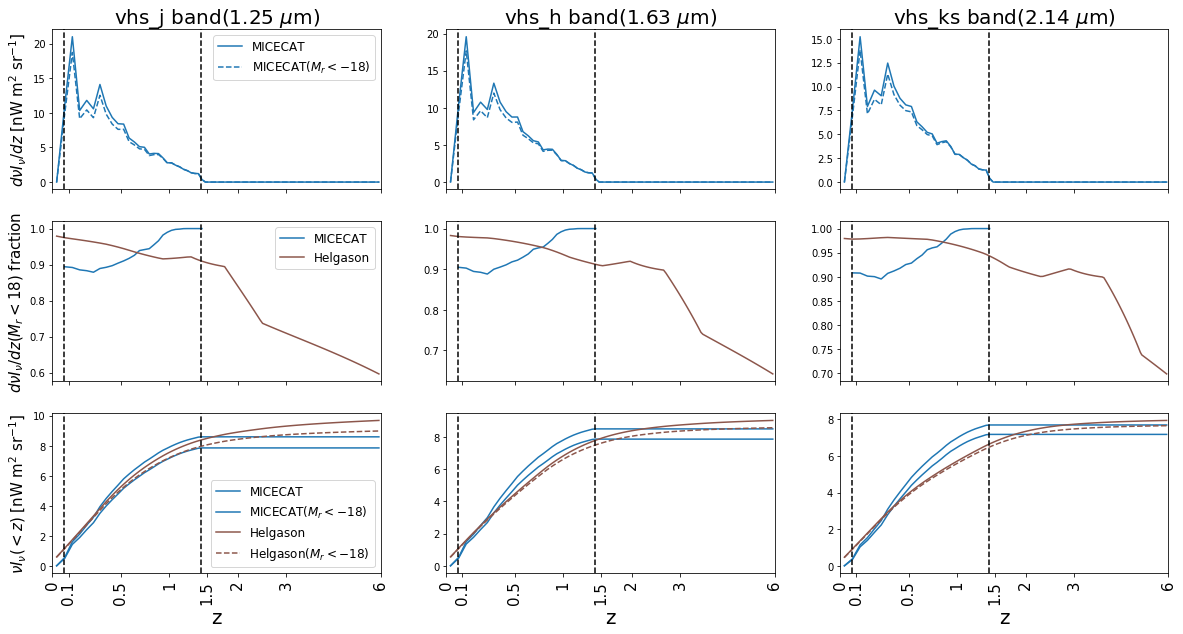

In [63]:
from Helgason import *

bandwl_dict = {'sdss_u':0.360804, 'sdss_g':0.467178, 'sdss_r':0.614112, 
               'sdss_i':0.745789, 'sdss_z':0.892278,
               'vhs_j':1.248100, 'vhs_h':1.634819, 'vhs_ks':2.143546}

abs_mag_cut = -18
idx_cut = np.where(df.sdss_r_abs_mag < abs_mag_cut)[0]
ra_min, ra_max = 40, 50
dec_min, dec_max = 0, 4
Omega_cat = (ra_max - ra_min) * (dec_max - dec_min)
zbinedges = np.arange(0,6,0.05)
zbins = (zbinedges[1:] + zbinedges[:-1])/2
dz = zbinedges[1] - zbinedges[0]
z_arr = df.z_cgal.values
DM_bins = 5 * np.log10((cosmo.luminosity_distance(zbins) / (10 * u.pc)).decompose()).value
mag_cut_bins = abs_mag_cut + DM_bins - 2.5*np.log10(1+zbins)
fig, ax = plt.subplots(3,3,figsize=(20,10))
for i, band_name in enumerate(['vhs_j','vhs_h','vhs_ks']):
    
    bandwl = bandwl_dict[band_name]
    bandnu = (bandwl * u.um).to(u.Hz, equivalencies=u.spectral()).value # Hz
    m_arr = df[band_name+'_true'].values - 0.8 * (np.arctan(1.5 * df.z_cgal.values) - 0.1489)
    nuFnu_arr = bandnu * (3631 * 10**(-m_arr / 2.5)) * (u.Jy*u.Hz).to(u.nW/u.m**2)
    nuInu_arr = nuFnu_arr / (Omega_cat * (u.deg**2).to(u.sr)) # nW/m2/sr
    
    dnuInu_dzm = np.histogram(z_arr, bins=zbinedges, weights=nuInu_arr)[0]/dz
    dnuInu_dzmb = np.histogram(z_arr[idx_cut], bins=zbinedges, weights=nuInu_arr[idx_cut])[0]/dz
    ax[0][i].plot(np.log10(1+zbins), dnuInu_dzm, 'C0-', label='MICECAT')
    ax[0][i].plot(np.log10(1+zbins), dnuInu_dzmb, 'C0--', label=r'MICECAT($M_r<-18$)')  
    ax[1][i].plot(np.log10(1+zbins), dnuInu_dzmb/dnuInu_dzm, 'C0-',
                  label=r'MICECAT')
    
    ax[2][i].plot(np.log10(1+zbins), np.cumsum(dnuInu_dzm*dz), 'C0-', label='MICECAT')
    ax[2][i].plot(np.log10(1+zbins), np.cumsum(dnuInu_dzmb*dz), label=r'MICECAT($M_r<-18$)')  

    dnuInu_dzhb = np.array([Helgason_model().dnuInu_dz(z,bandwl, m_max=mag_cut,
                                                     wl_obs_th_ref=bandwl_dict['sdss_r'])\
                           for z,mag_cut in zip(zbins,mag_cut_bins)]) # nW/m2/sr
    dnuInu_dzh = np.array([Helgason_model().dnuInu_dz(z,bandwl) for z in zbins]) # nW/m2/sr
    ax[1][i].plot(np.log10(1+zbins), dnuInu_dzhb/dnuInu_dzh, 'C5-', 
                  label=r'Helgason')
    ax[2][i].plot(np.log10(1+zbins), np.cumsum(dnuInu_dzh*dz), 'C5-', label='Helgason')
    ax[2][i].plot(np.log10(1+zbins), np.cumsum(dnuInu_dzhb*dz), 'C5--',
                  label='Helgason($M_r<-18$)')  
    ax[0][i].set_title(r'%s band'%(band_name)+r'(%.2f $\mu$m)'%(bandwl), fontsize=20)
    ax[0][i].set_xticks(np.log10(1+np.array([0,0.1,0.5,1,1.5,2,3,6])))
    ax[1][i].set_xticks(np.log10(1+np.array([0,0.1,0.5,1,1.5,2,3,6])))
    ax[2][i].set_xticks(np.log10(1+np.array([0,0.1,0.5,1,1.5,2,3,6])))
    ax[0][i].set_xticklabels([])
    ax[1][i].set_xticklabels([])
    ax[2][i].set_xticklabels(['0','0.1','0.5','1','1.5','2','3','6'],rotation=90,fontsize=15)
    ax[2][i].set_xlabel('z', fontsize=20)
    ax[0][i].axvline(np.log10(1+min(z_arr)),c='k',ls='--')
    ax[0][i].axvline(np.log10(1+max(z_arr)),c='k',ls='--')
    ax[1][i].axvline(np.log10(1+min(z_arr)),c='k',ls='--')
    ax[1][i].axvline(np.log10(1+max(z_arr)),c='k',ls='--')
    ax[2][i].axvline(np.log10(1+min(z_arr)),c='k',ls='--')
    ax[2][i].axvline(np.log10(1+max(z_arr)),c='k',ls='--')
    ax[0][i].set_xlim([np.log10(1+0), np.log10(1+6)])
    ax[1][i].set_xlim([np.log10(1+0), np.log10(1+6)])
    ax[2][i].set_xlim([np.log10(1+0), np.log10(1+6)])
ax[0][0].legend(fontsize=12)
ax[1][0].legend(fontsize=12)
ax[2][0].legend(fontsize=12)
ax[0][0].set_ylabel(r'$d\nu I_\nu/dz$ [nW m$^2$ sr$^{-1}$]',fontsize=15)
ax[1][0].set_ylabel(r'$d\nu I_\nu/dz(M_r<18)$ fraction',fontsize=15)
ax[2][0].set_ylabel(r'$\nu I_\nu(<z)$ [nW m$^2$ sr$^{-1}$]',fontsize=15)
# fig.savefig('plots/IHL/LFcum_VHS_z.pdf', dpi = 100, bbox_inches='tight')

In [1]:
# from micecat_field import *

# ra_arr = np.arange(32,59,2)[::2]
# dec_arr = np.arange(2,29,3)[::2]
# bandname = 'ciber_I'
# abs_mag_cut = -18

# Cl_data = {'bandname': bandname, 'ra_arr':ra_arr, 'dec_arr':dec_arr}

# dec_grid, ra_grid = np.meshgrid(dec_arr, ra_arr)
# for ifield, (ra_cent, dec_cent) in enumerate(zip(ra_grid.flatten(), dec_grid.flatten())):
#     print('field {}, ra = {}, dec = {}'.format(ifield, ra_cent, dec_cent))
        
#     Cl_data[ifield] = {'ra_cent': ra_cent, 'dec_cent': dec_cent}
    
#     mcfield = micecat_field(ra_cent, dec_cent,Nx=1024,Ny=1024)
#     df = mcfield.get_micecat_df(add_fields=['sdss_r_abs_mag'])

#     for iz, z_mid in enumerate([None, 0.1, 0.2, 0.5, 1]):
#         if z_mid == None:
#             z_min, z_max = 0, 1.4
#         else:
#             delz = 0.05
#             Dz = (1 + z_mid) * delz
#             z_min, z_max = z_mid - Dz/2, z_mid + Dz/2

#         Cl_data[ifield][iz] = {'z': z_mid, 'z_min': z_min, 'z_max':z_max}
        
#         for im_th, m_th in enumerate([-np.inf, 17, 20]):
            
#             Cl_data[ifield][iz][im_th] = {'m_th': m_th}
        
#             dfi = df[(df.z_cgal >= z_min) & (df.z_cgal < z_max) \
#                      & (df[bandname+'_true'] > m_th)]
#             dfib = dfi[dfi.sdss_r_abs_mag <= abs_mag_cut]

#             srcmapb_all = mcfield.make_map(bandname, df=dfib)
#             srcmap_all = mcfield.make_map(bandname, df=dfi)

#             dfi = df[(df.z_cgal >= z_min) & (df.z_cgal < z_max)]
#             srcmap_allcen = mcfield.make_map_central(bandname, df=dfi, 
#                                                      band_mask=bandname, m_th=m_th)

#             dfib = df[(df.z_cgal >= z_min) & (df.z_cgal < z_max) \
#                       & (df.sdss_r_abs_mag <= abs_mag_cut)]
#             srcmapb_allcen = mcfield.make_map_central(bandname, df=dfib, 
#                                                      band_mask=bandname, m_th=m_th)

#             l,Cla, Claerr = get_power_spec(srcmap_all)
#             l,Clac, Clacerr = get_power_spec(srcmap_allcen)
#             Cla_shsub = Cla-np.mean(Cla[-3:])
#             Clac_shsub = Clac-np.mean(Clac[-3:])
            
#             l,Clab, Claberr = get_power_spec(srcmapb_all)
#             l,Clacb, Clacberr = get_power_spec(srcmapb_allcen)
#             Clab_shsub = Clab-np.mean(Clab[-3:])
#             Clacb_shsub = Clacb-np.mean(Clacb[-3:])
            
#             Cl_data[ifield]['l'] = l
#             Cl_data[ifield][iz][im_th]['Cla'] = Cla
#             Cl_data[ifield][iz][im_th]['Clac'] = Clac
#             Cl_data[ifield][iz][im_th]['Cla_shsub'] = Cla_shsub
#             Cl_data[ifield][iz][im_th]['Clac_shsub'] = Clac_shsub  

#             Cl_data[ifield][iz][im_th]['Clab'] = Clab
#             Cl_data[ifield][iz][im_th]['Clacb'] = Clacb
#             Cl_data[ifield][iz][im_th]['Clab_shsub'] = Clab_shsub
#             Cl_data[ifield][iz][im_th]['Clacb_shsub'] = Clacb_shsub  

# clear_output()

# fname = 'micecat_Cl_data_Mabs_cut.pkl'
# with open(fname, "wb") as f:
#     pickle.dump(Cl_data , f)

/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:64: RuntimeWarning: invalid value encountered in true_divide
/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:69: RuntimeWarning: invalid value encountered in true_divide


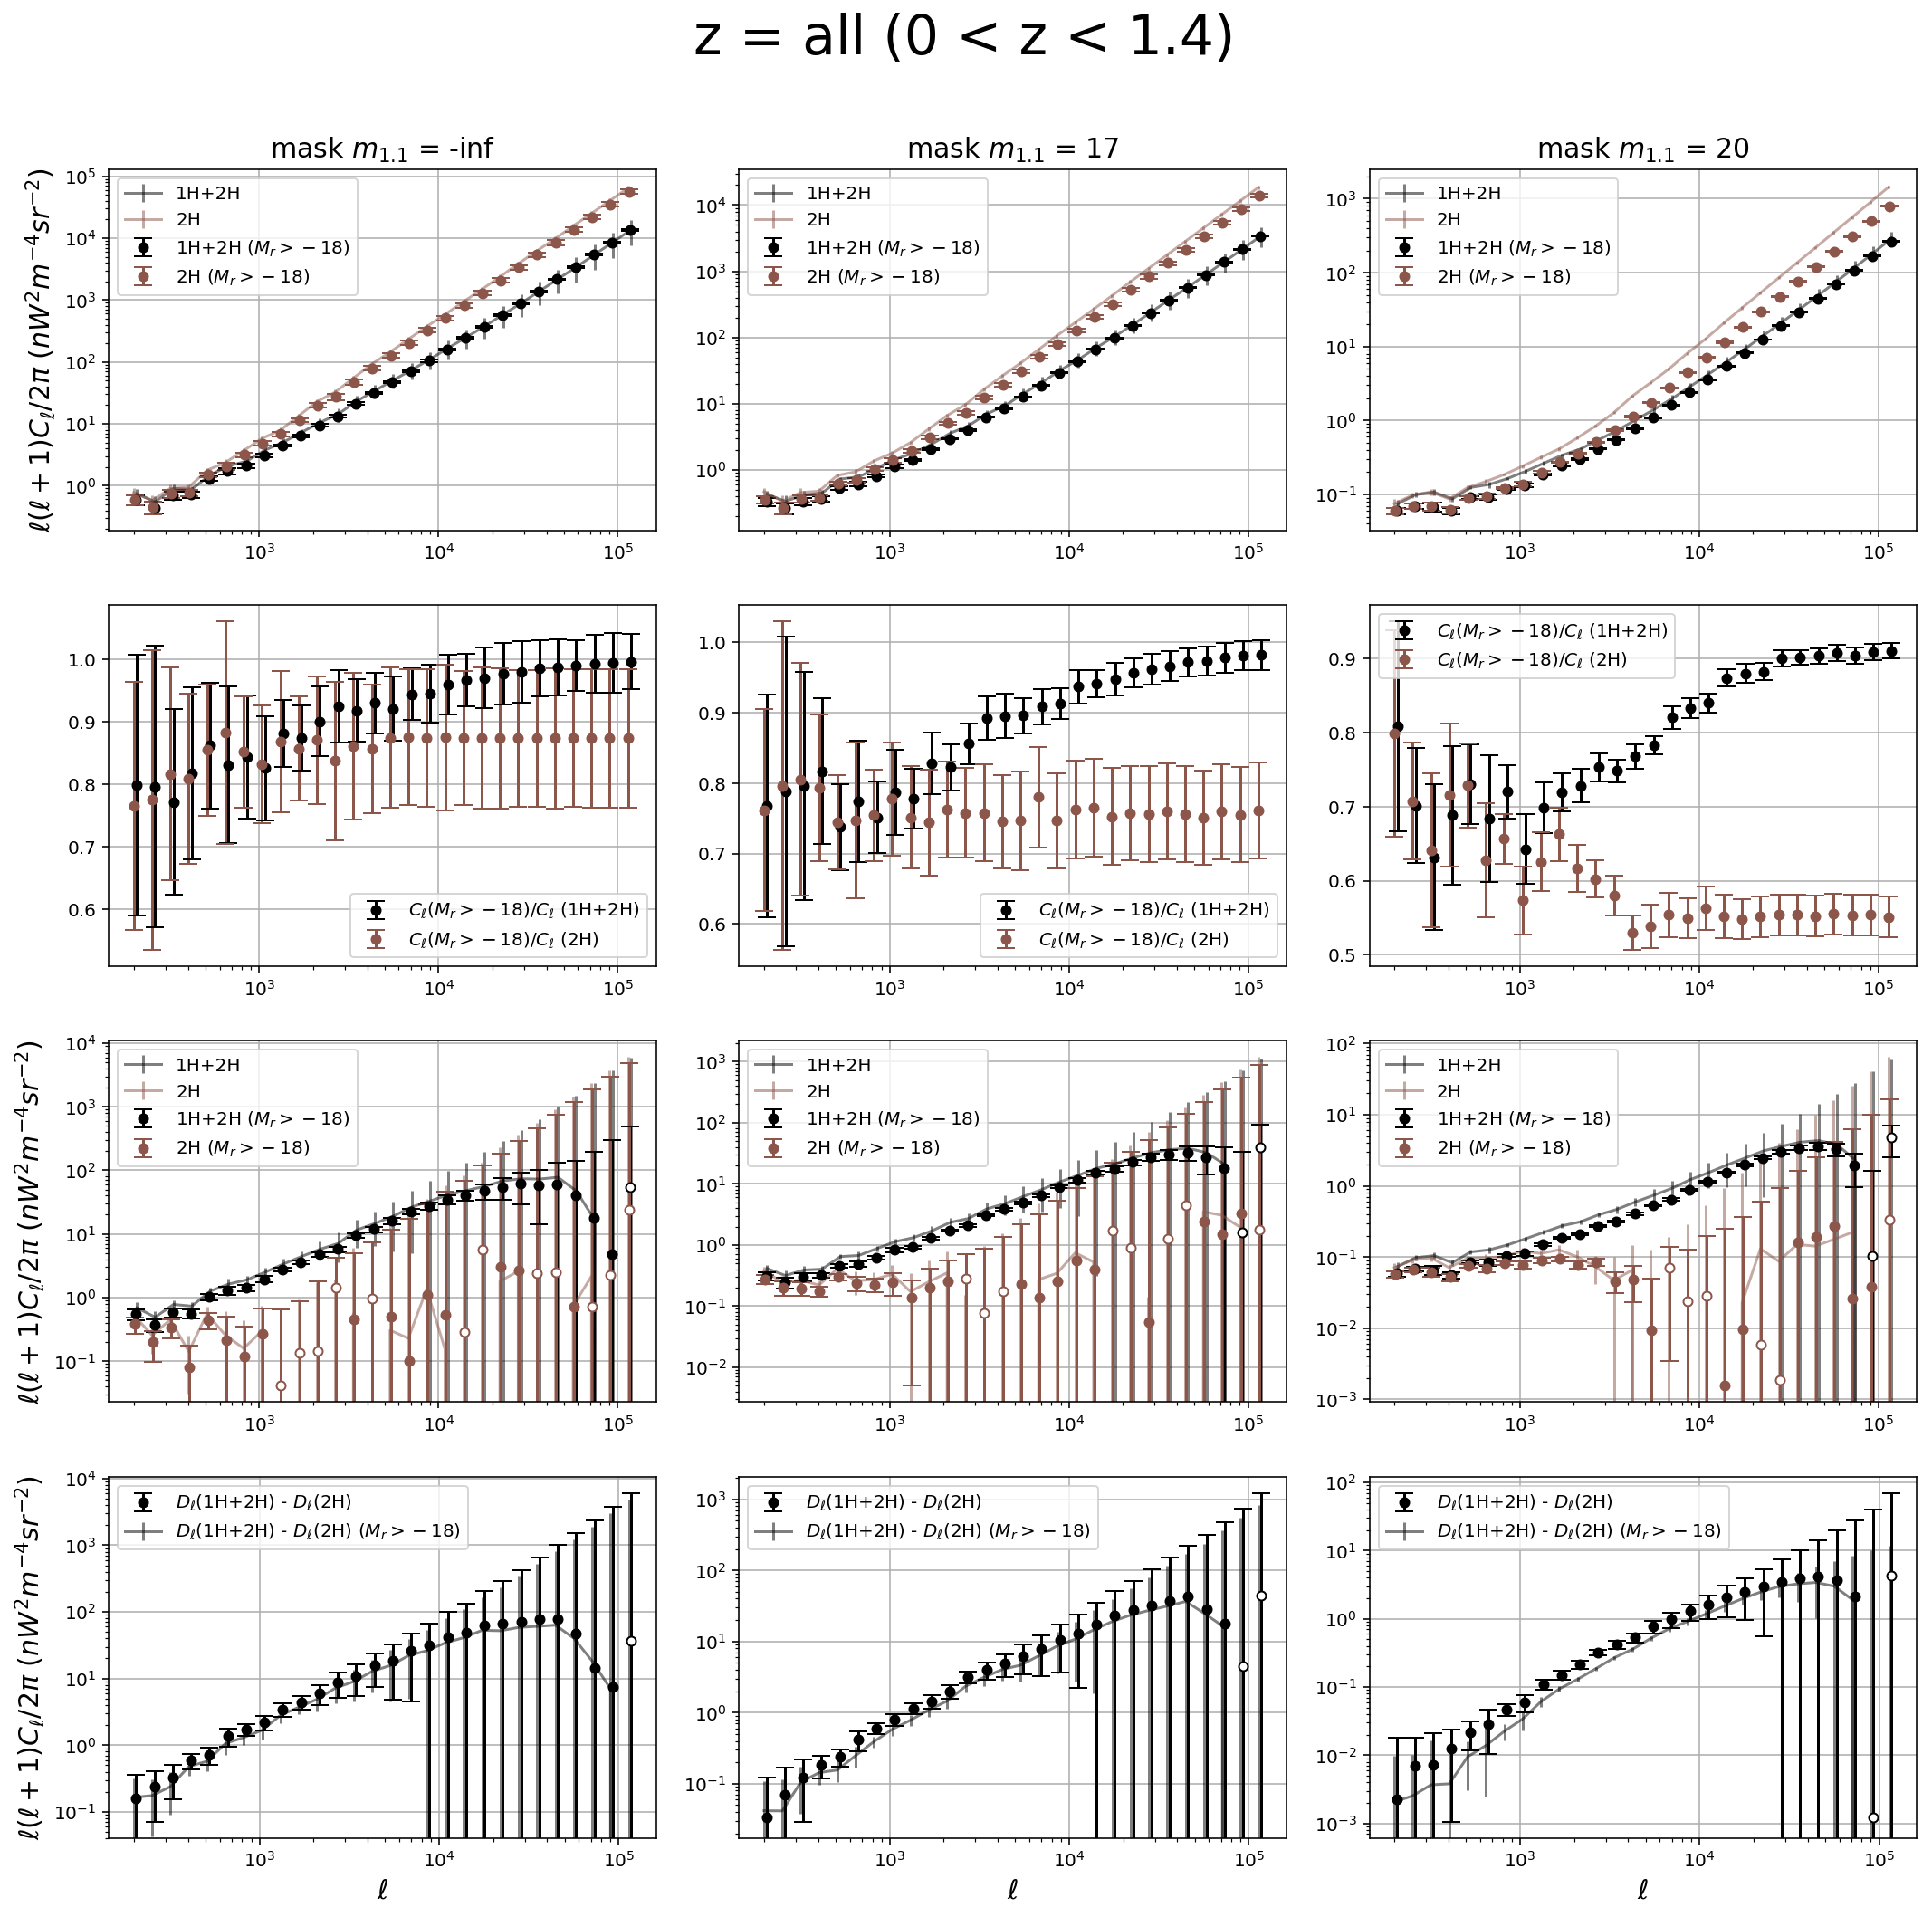

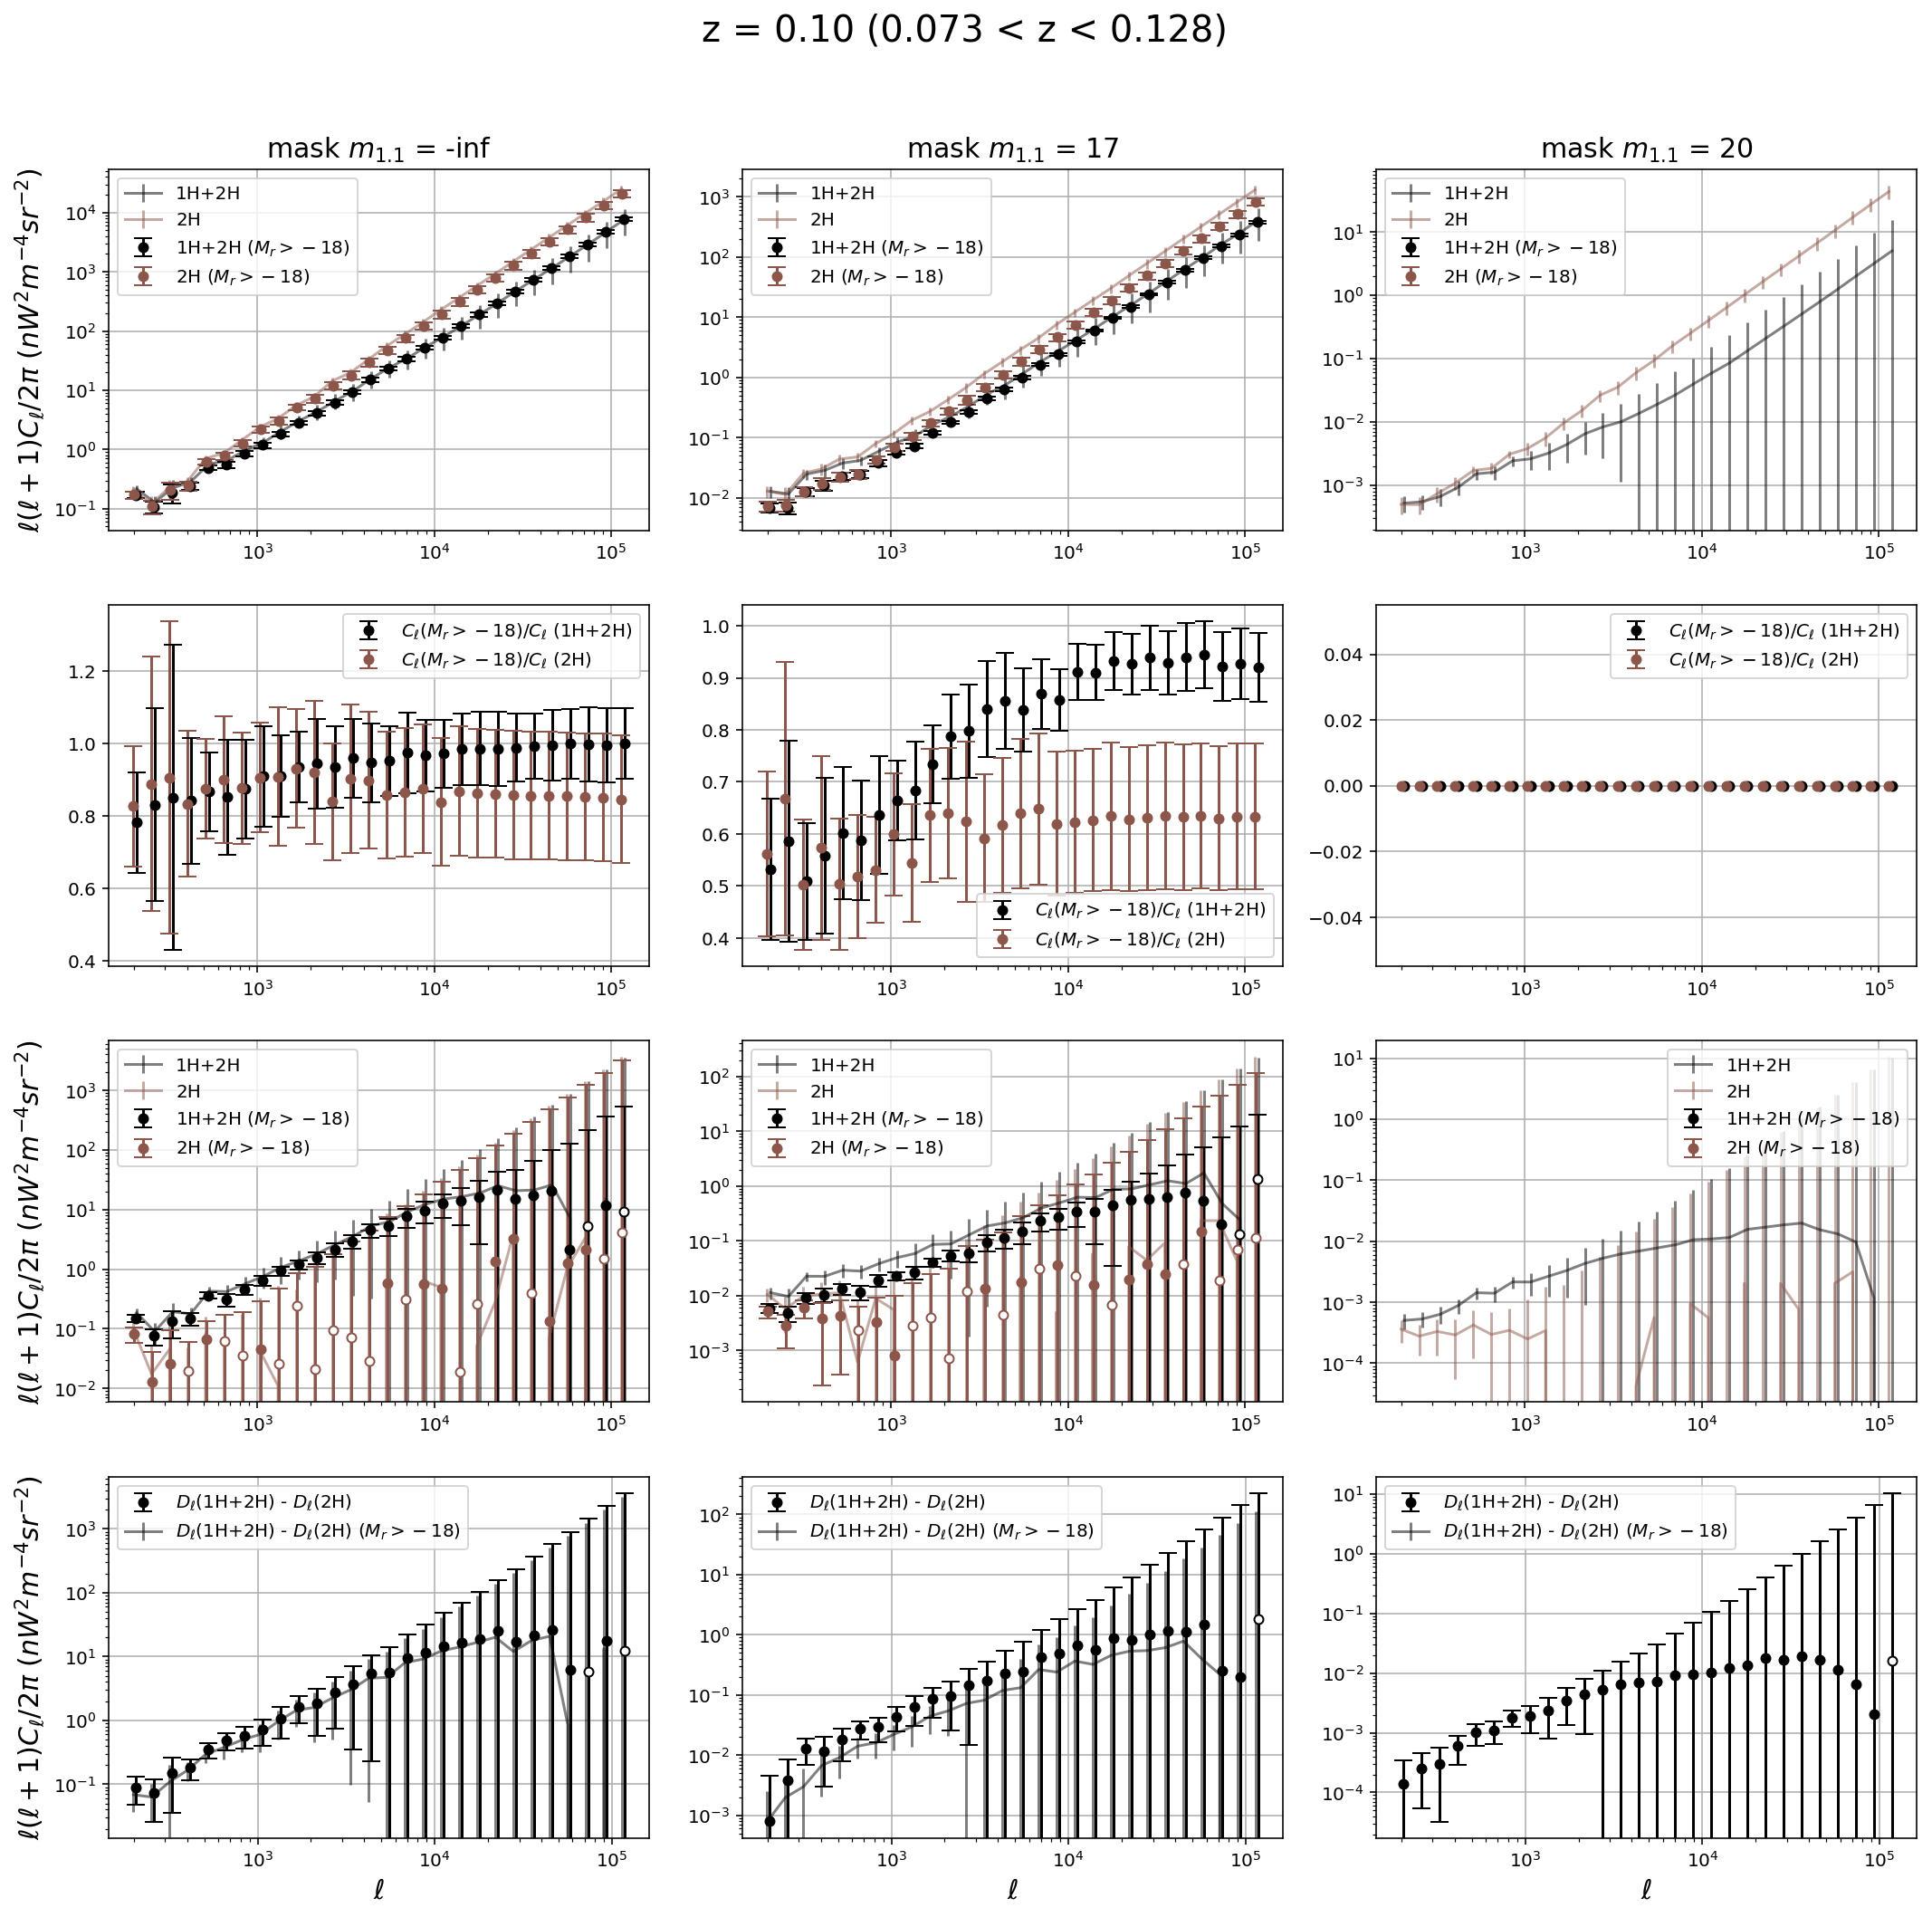

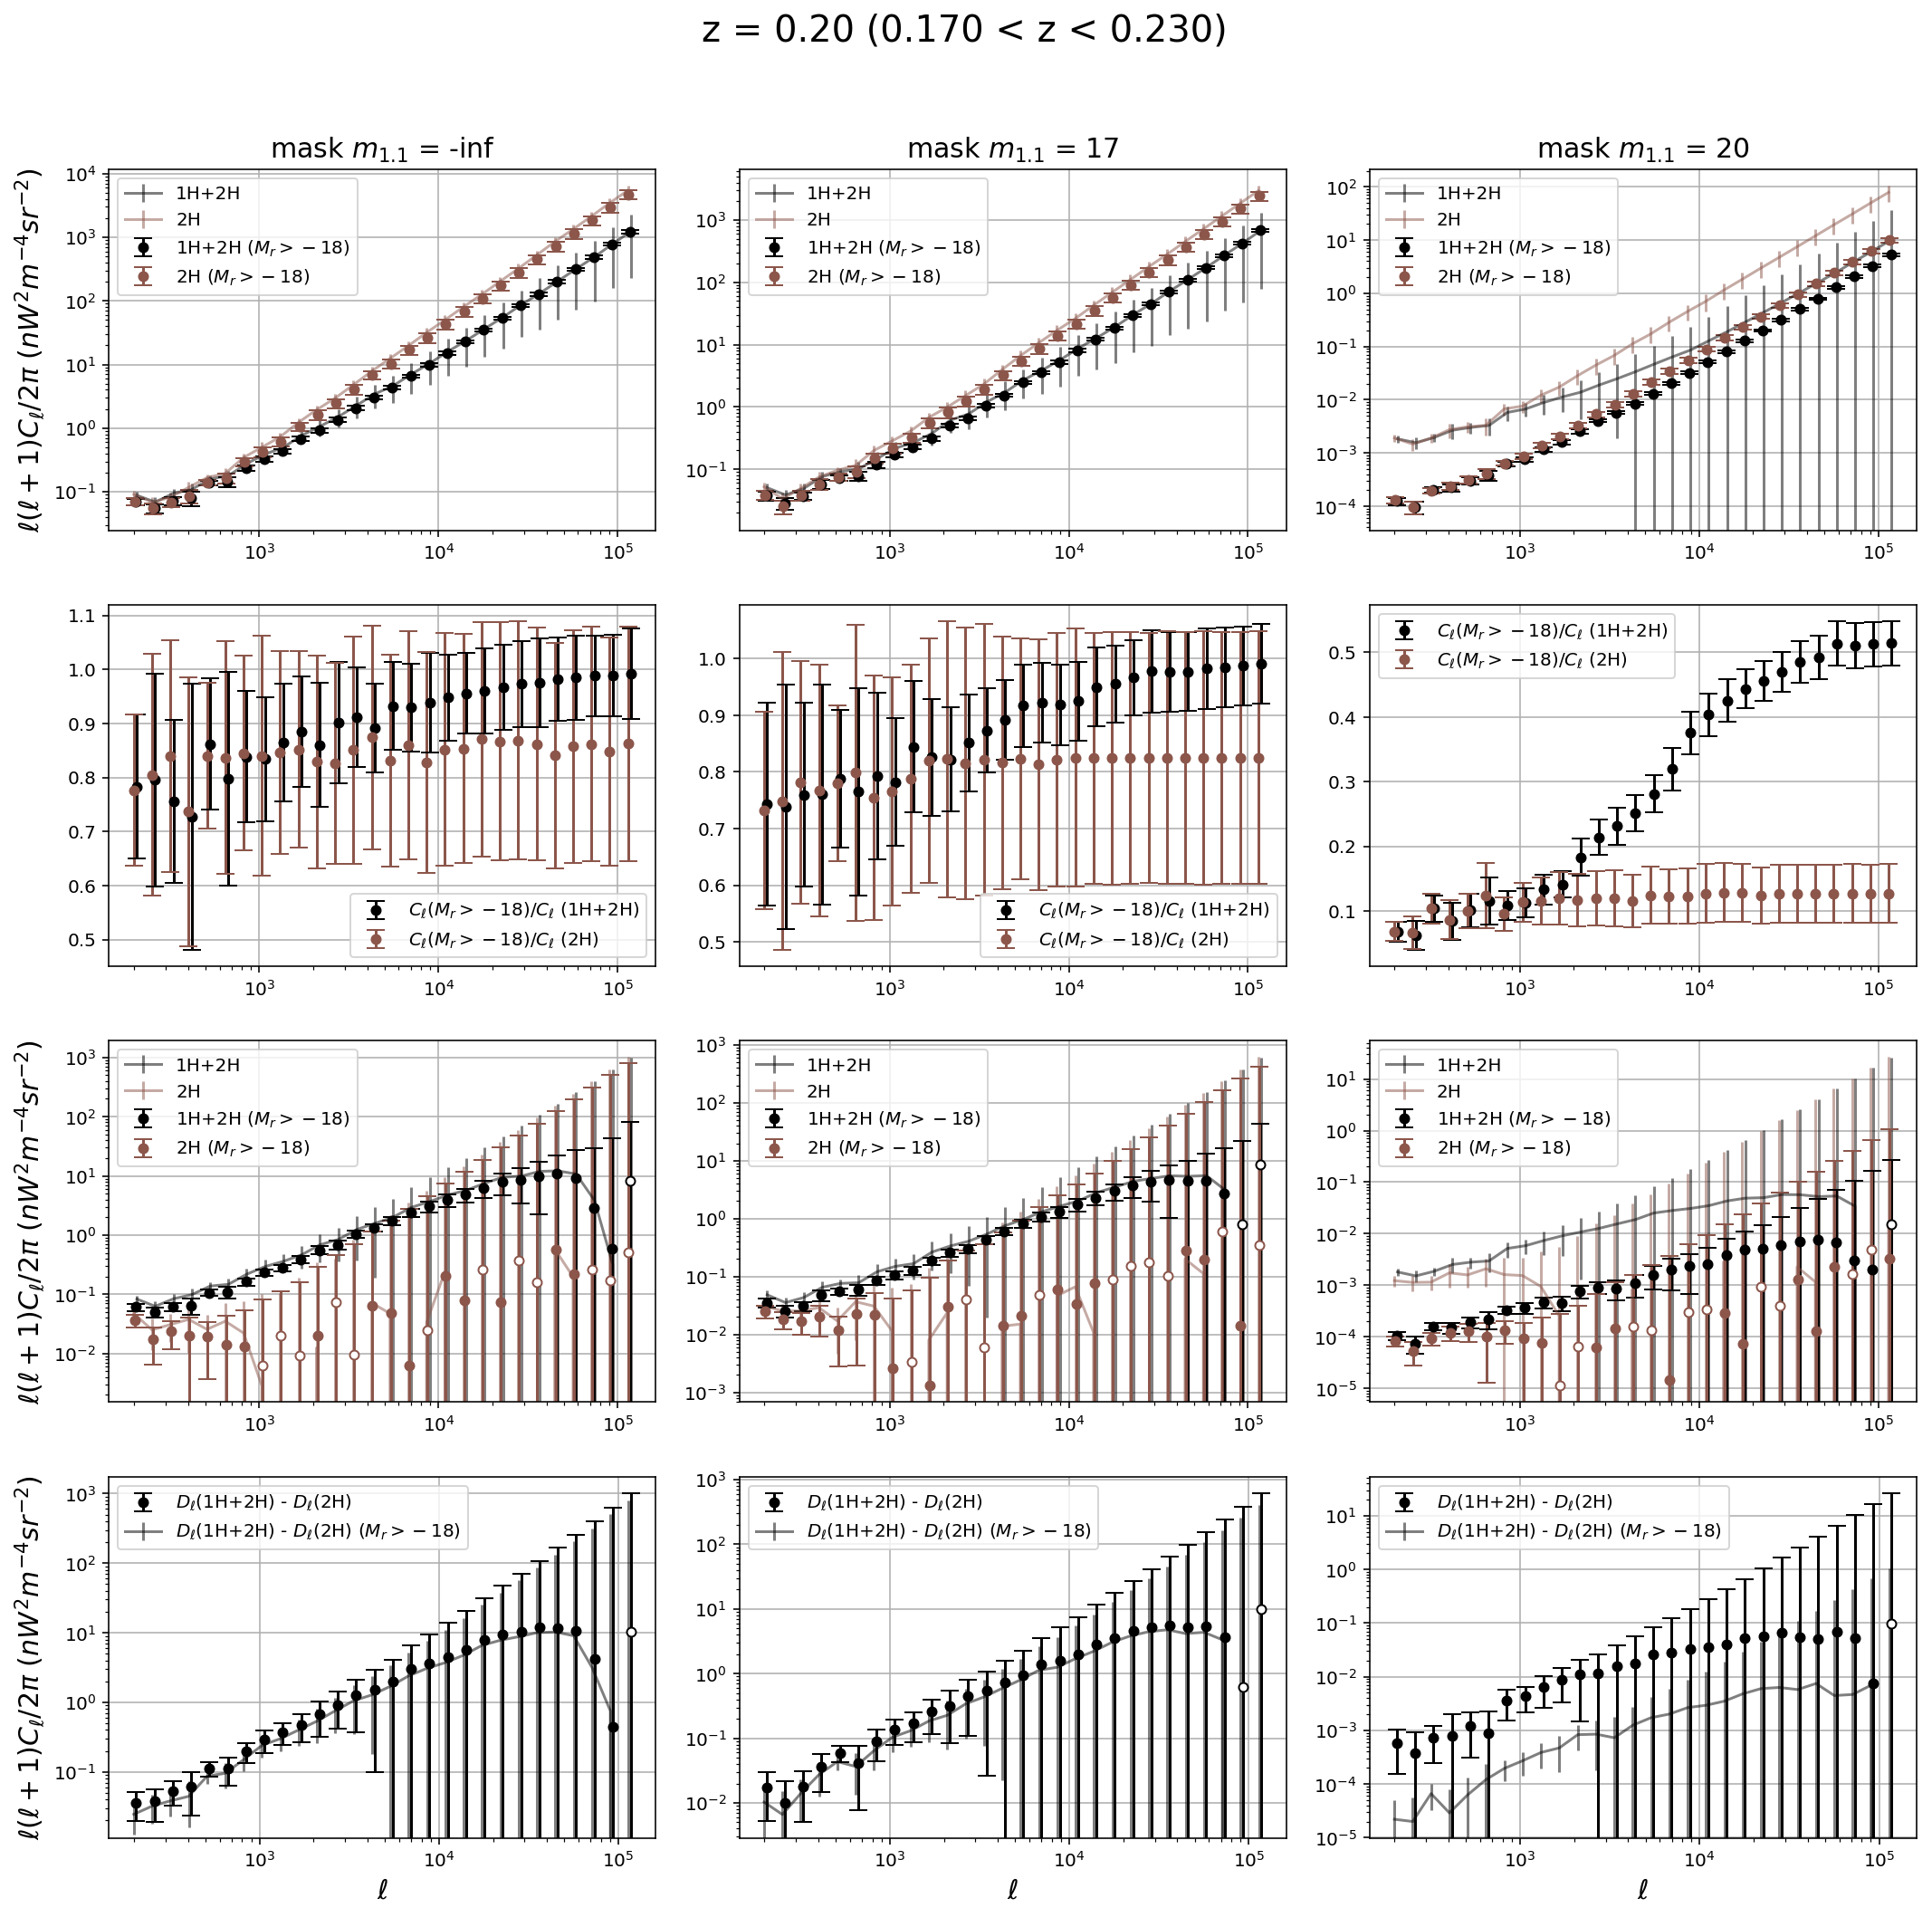

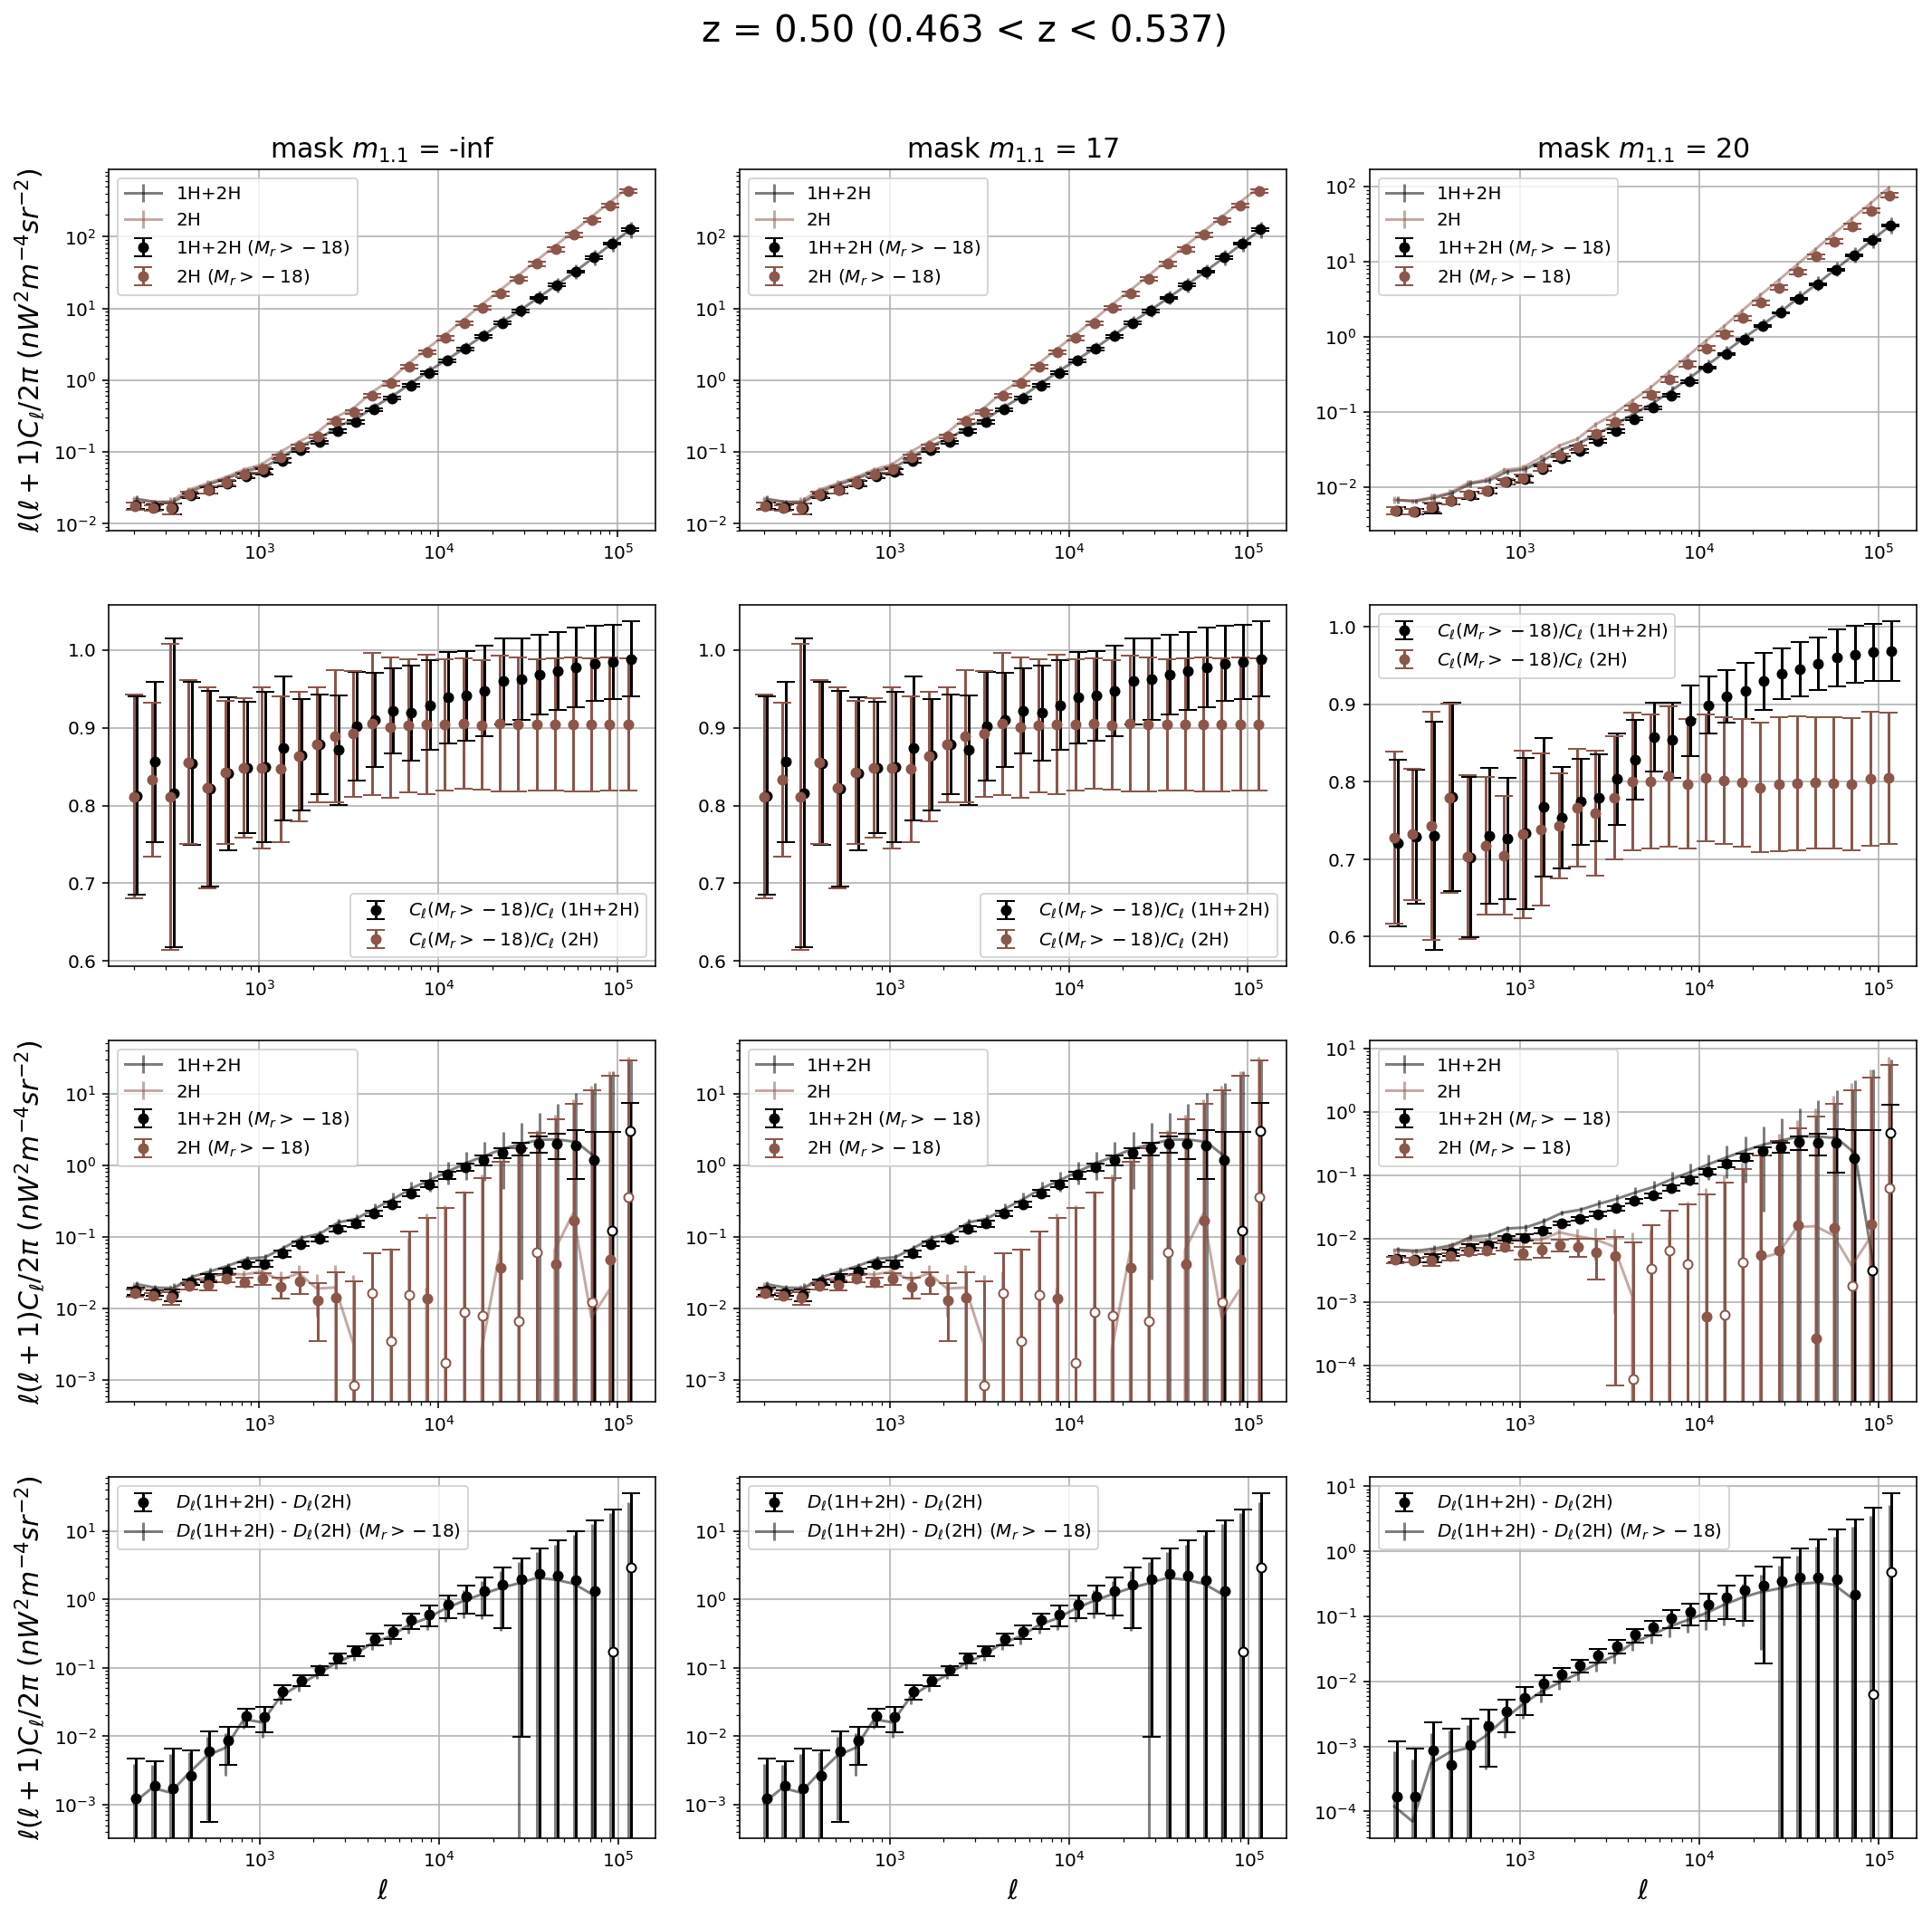

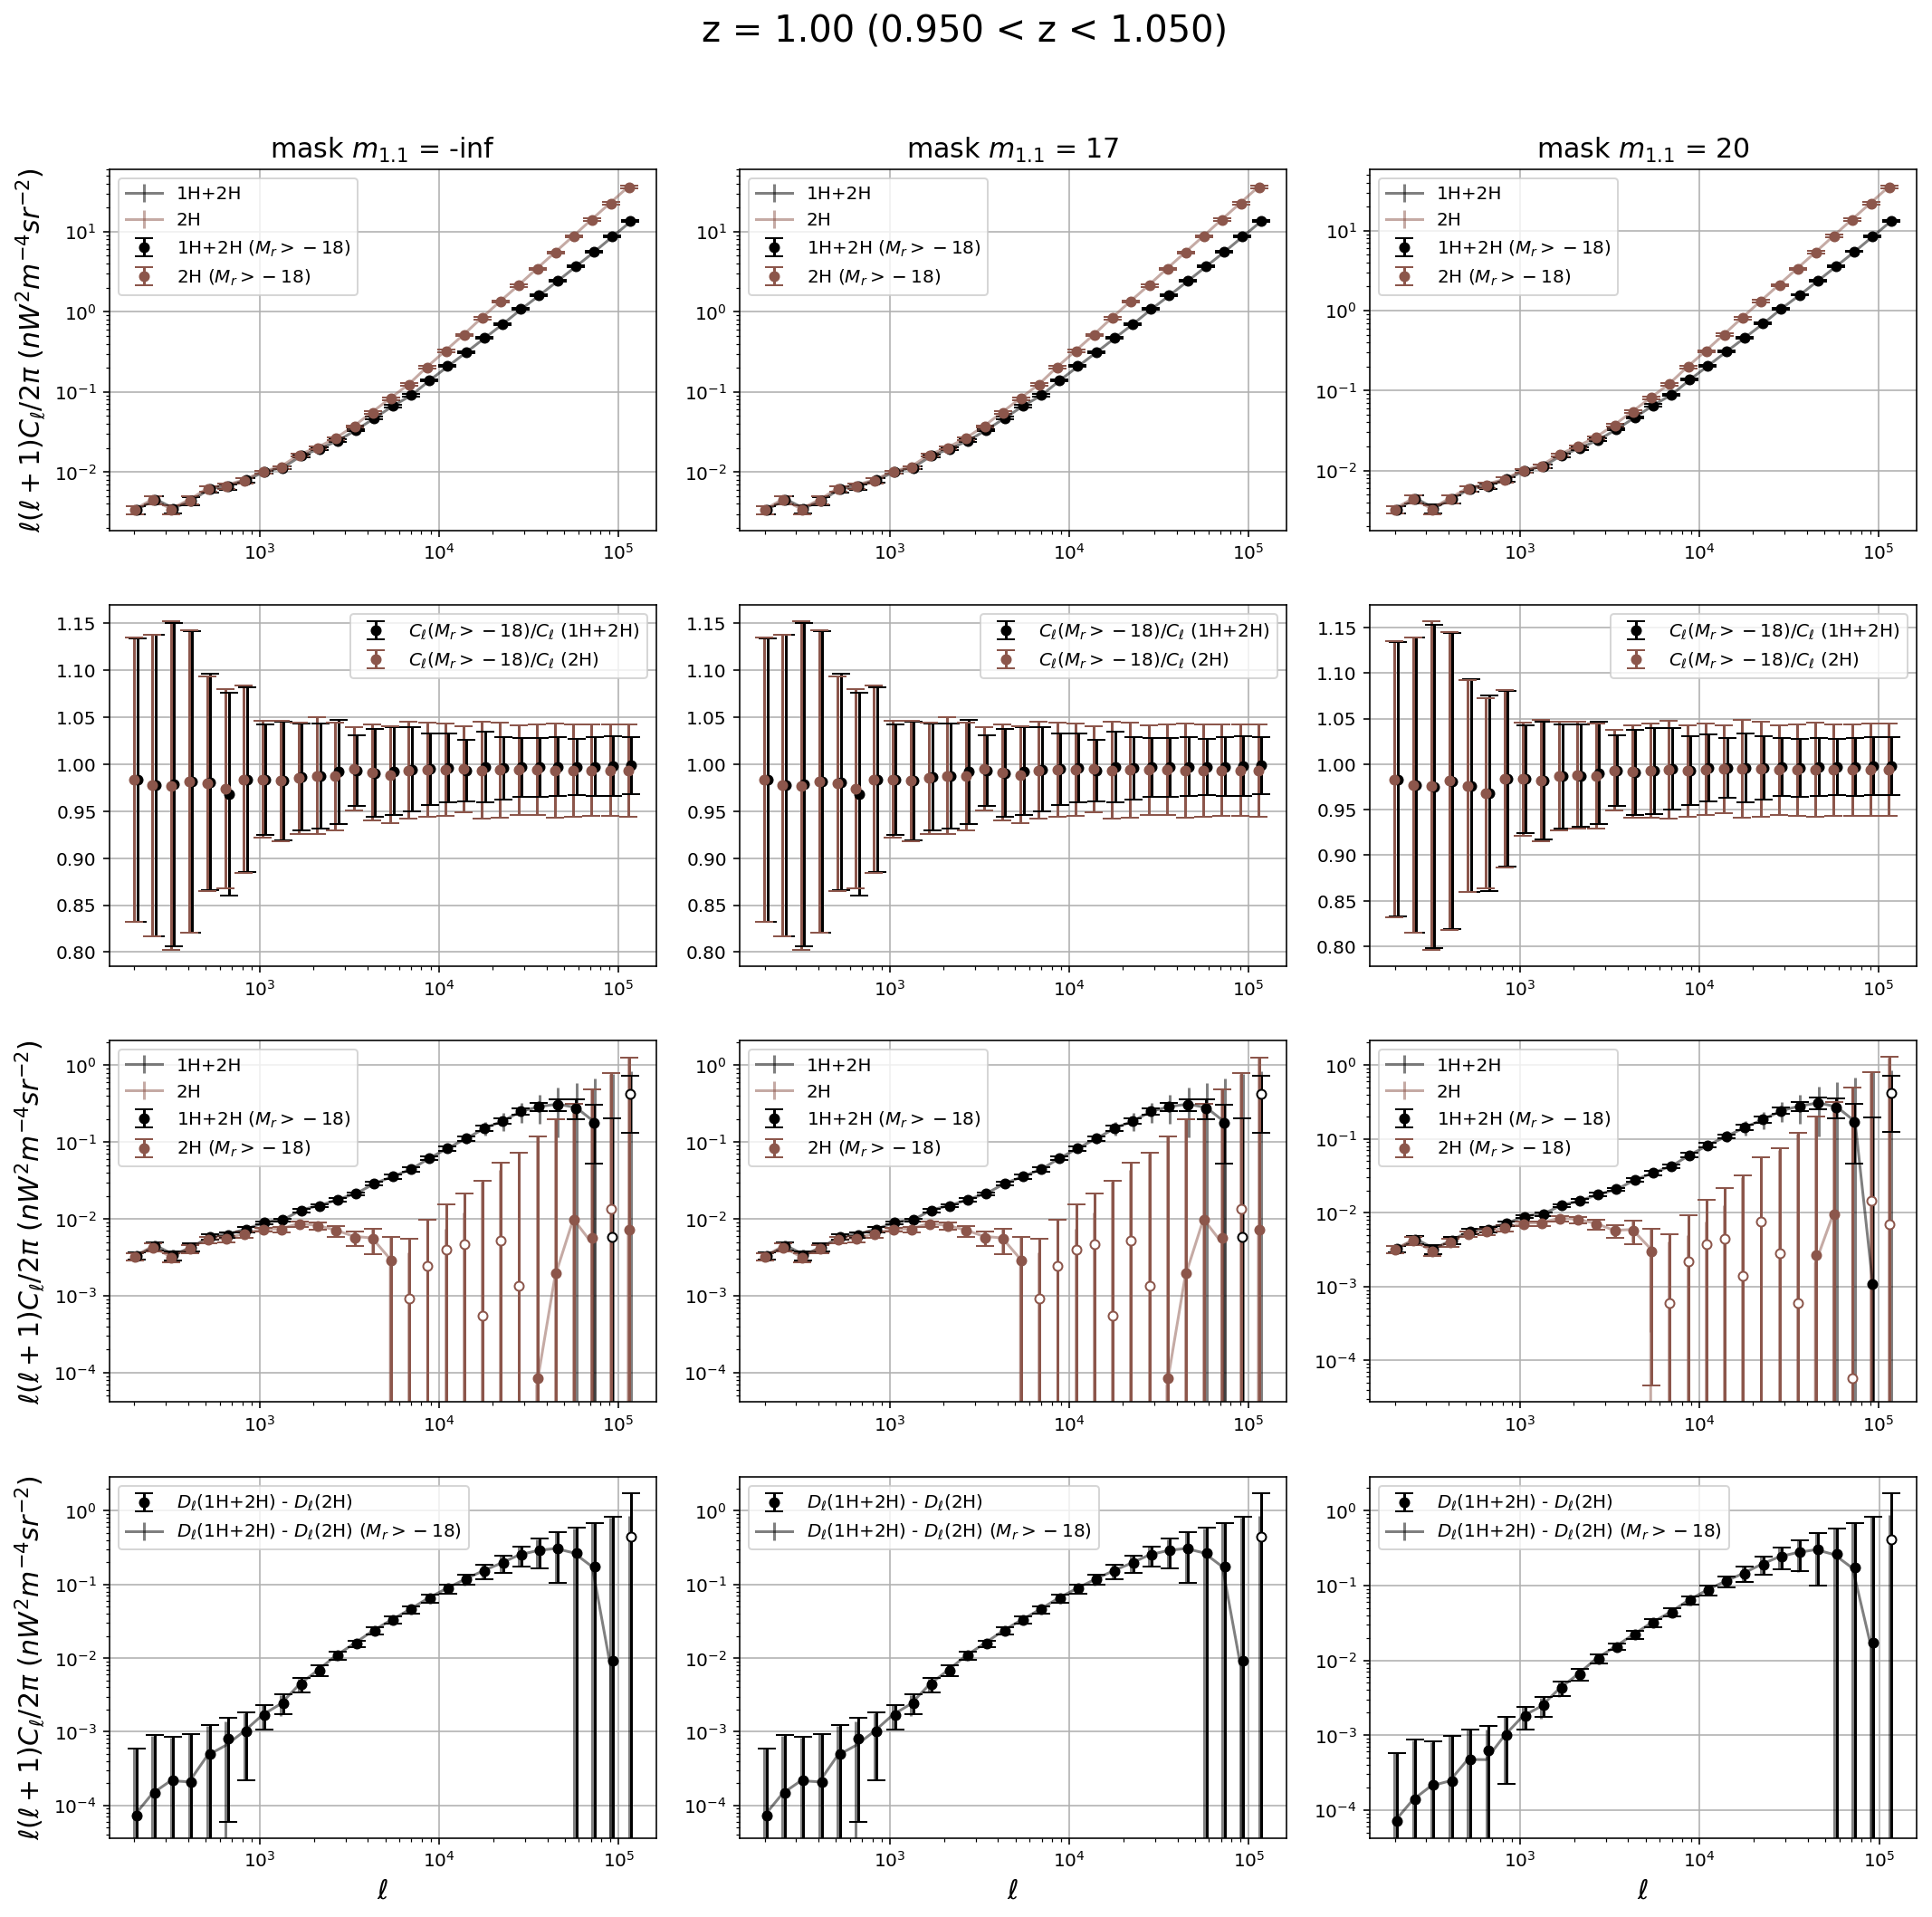

In [20]:
# # %config InlineBackend.figure_format = 'retina'
# from micecat_field import *

# fname = 'micecat_Cl_data_Mabs_cut.pkl'
# with open(fname, "rb") as f:
#     Cl_data = pickle.load(f)

# ra_arr = Cl_data['ra_arr']
# dec_arr = Cl_data['dec_arr']
# dec_grid, ra_grid = np.meshgrid(dec_arr, ra_arr)
# Nfields = len(ra_arr)*len(dec_arr)
# l = Cl_data[0]['l']

# for iz, z_mid in enumerate([None, 0.1, 0.2, 0.5, 1]):
#     z_min, z_max = Cl_data[0][iz]['z_min'], Cl_data[0][iz]['z_max']
    
#     fig, ax = plt.subplots(4,3, figsize=(15,15))
#     for im_th in range(3):
#         m_th = Cl_data[0][iz][im_th]['m_th']

#         Dla, Dlac, Dlab, Dlacb = [], [], [], []
#         Dla_shsub, Dlac_shsub, Dlab_shsub, Dlacb_shsub = [], [], [], []

#         for ifield, (ra_cent, dec_cent) in enumerate(zip(ra_grid.flatten(), dec_grid.flatten())):
#             Dla.append(Cl_data[ifield][iz][im_th]['Cla']*l*(l+1)/2/np.pi)
#             Dla_shsub.append(Cl_data[ifield][iz][im_th]['Cla_shsub']*l*(l+1)/2/np.pi)
#             Dlac.append(Cl_data[ifield][iz][im_th]['Clac']*l*(l+1)/2/np.pi)
#             Dlac_shsub.append(Cl_data[ifield][iz][im_th]['Clac_shsub']*l*(l+1)/2/np.pi)
            
#             Dlab.append(Cl_data[ifield][iz][im_th]['Clab']*l*(l+1)/2/np.pi)
#             Dlab_shsub.append(Cl_data[ifield][iz][im_th]['Clab_shsub']*l*(l+1)/2/np.pi)
#             Dlacb.append(Cl_data[ifield][iz][im_th]['Clacb']*l*(l+1)/2/np.pi)
#             Dlacb_shsub.append(Cl_data[ifield][iz][im_th]['Clacb_shsub']*l*(l+1)/2/np.pi)
        
#         Dlaerr = (np.percentile(Dla, 84, axis=0)\
#                   -np.percentile(Dla, 16, axis=0))/2/np.sqrt(Nfields)
#         Dla = np.median(Dla, axis=0) 
#         Dlacerr = (np.percentile(Dlac, 84, axis=0)\
#                    -np.percentile(Dlac, 16, axis=0))/2/np.sqrt(Nfields)
#         Dlac = np.median(Dlac, axis=0)

#         Dlaberr = (np.percentile(Dlab, 84, axis=0)\
#                   -np.percentile(Dlab, 16, axis=0))/2/np.sqrt(Nfields)
#         Dlab = np.median(Dlab, axis=0) 
#         Dlacberr = (np.percentile(Dlacb, 84, axis=0)\
#                    -np.percentile(Dlacb, 16, axis=0))/2/np.sqrt(Nfields)
#         Dlacb = np.median(Dlacb, axis=0)

#         Dla_shsub = np.median(Dla_shsub, axis=0) 
#         Dlac_shsub = np.median(Dlac_shsub, axis=0)
#         Dlab_shsub = np.median(Dlab_shsub, axis=0) 
#         Dlacb_shsub = np.median(Dlacb_shsub, axis=0)
        

#         ax[0][im_th].errorbar(l*1.02, Dla, Dlacerr, c='k', alpha=0.5,
#                           label='1H+2H')
#         ax[0][im_th].errorbar(l*0.98, Dlac, Dlacerr, c='C5', alpha=0.5,
#                           label='2H')
#         plot_err_log(l*1.01, Dlab, Dlaberr, ax=ax[0][im_th], xlog=True, plot_xerr=False, 
#                          color='k', capsize=5, markersize=10, 
#                      label=r'1H+2H ($M_r>-18$)')
#         plot_err_log(l*0.99, Dlacb, Dlacberr, ax=ax[0][im_th], xlog=True, plot_xerr=False, 
#                          color='C5', capsize=5, markersize=10, 
#                     label='2H ($M_r>-18$)')
#         ax[0][im_th].grid()
#         ax[0][im_th].legend()
        
#         d_arr = Dlab / Dla
#         d_arrerr = d_arr * np.sqrt((Dlaberr/ Dlab)**2 + (Dlaerr/ Dla)**2)
#         ax[1][im_th].errorbar(l*1.02, d_arr, d_arrerr, c='k', alpha=1,
#                               capsize=5, markersize=10,fmt ='.',
#                           label=r'$C_\ell$($M_r>-18$)/$C_\ell$ (1H+2H)')
#         d_arr = Dlacb / Dlac
#         d_arrerr = d_arr * np.sqrt((Dlacberr/ Dlacb)**2 + (Dlacerr/ Dlac)**2)        
#         ax[1][im_th].errorbar(l*0.98, d_arr, d_arrerr, c='C5', alpha=1,
#                               capsize=5, markersize=10,fmt ='.',
#                           label=r'$C_\ell$($M_r>-18$)/$C_\ell$ (2H)')
#         ax[1][im_th].set_xscale('log')
#         ax[1][im_th].grid()
#         ax[1][im_th].legend()
        
#         ax[2][im_th].errorbar(l*1.02, Dla_shsub, Dlacerr, c='k', alpha=0.5,
#                           label='1H+2H')
#         ax[2][im_th].errorbar(l*0.98, Dlac_shsub, Dlacerr, c='C5', alpha=0.5,
#                           label='2H')
#         plot_err_log(l*1.01, Dlab_shsub, Dlaberr, ax=ax[2][im_th], xlog=True, plot_xerr=False, 
#                          color='k', capsize=5, markersize=10, 
#                      label=r'1H+2H ($M_r>-18$)')
#         plot_err_log(l*0.99, Dlacb_shsub, Dlacberr, ax=ax[2][im_th], xlog=True, plot_xerr=False, 
#                          color='C5', capsize=5, markersize=10, 
#                     label='2H ($M_r>-18$)')
#         ax[2][im_th].grid()
#         ax[2][im_th].legend()
        
#         d_arr = Dla_shsub - Dlac_shsub
#         d_arrerr = np.sqrt((Dlaerr)**2 + (Dlacerr)**2)
#         plot_err_log(l*1.01, d_arr, d_arrerr, ax=ax[3][im_th], xlog=True, plot_xerr=False, 
#                          color='k', capsize=5, markersize=10, 
#                      label=r'$D_\ell$(1H+2H) - $D_\ell$(2H)')
#         d_arr = Dlab_shsub - Dlacb_shsub
#         d_arrerr = np.sqrt((Dlaberr)**2 + (Dlacberr)**2)
#         ax[3][im_th].errorbar(l*0.98, d_arr, d_arrerr, c='k', alpha=0.5,
#                           label=r'$D_\ell$(1H+2H) - $D_\ell$(2H) ($M_r>-18$)')
#         ax[3][im_th].set_xscale('log')
#         ax[3][im_th].set_yscale('log')
#         ax[3][im_th].grid()
#         ax[3][im_th].legend()
        
#         ax[0][im_th].set_title(r'mask $m_{1.1}$ = ' + '{}'.format(m_th), fontsize=15)
#         ax[3][im_th].set_xlabel('$\ell$', fontsize=15)
        
#     ax[0][0].set_ylabel(r'$\ell(\ell+1)C_\ell/2\pi$ $(nW^{2}m^{-4} sr^{-2})$', fontsize=15)
#     ax[2][0].set_ylabel(r'$\ell(\ell+1)C_\ell/2\pi$ $(nW^{2}m^{-4} sr^{-2})$', fontsize=15)
#     ax[3][0].set_ylabel(r'$\ell(\ell+1)C_\ell/2\pi$ $(nW^{2}m^{-4} sr^{-2})$', fontsize=15)
#     fig.tight_layout()
#     fig.subplots_adjust(top=0.90)
#     if z_mid is None:
#         fig.suptitle('z = all (0 < z < 1.4)', fontsize=30)
#     else:
#         fig.suptitle('z = {:.2f} ({:.3f} < z < {:.3f})'.format(z_mid, z_min, z_max), fontsize=20)

***

In [1]:
# %config InlineBackend.figure_format = 'retina'
# from micecat_field import *

# bandname = 'ciber_I'
# abs_mag_cut = -18
# m_th = 20
# ra_cent, dec_cent = 32, 2
# mcfield = micecat_field(ra_cent, dec_cent,Nx=1024,Ny=1024)
# df_all = mcfield.get_micecat_df(add_fields=['sdss_r_abs_mag'])
# df = df_all[(df_all[bandname+'_true'] > m_th) & (df_all.sdss_r_abs_mag <= abs_mag_cut)]

Text(0.5, 0, '$R_{\\rm vir}$ [arcsec]')

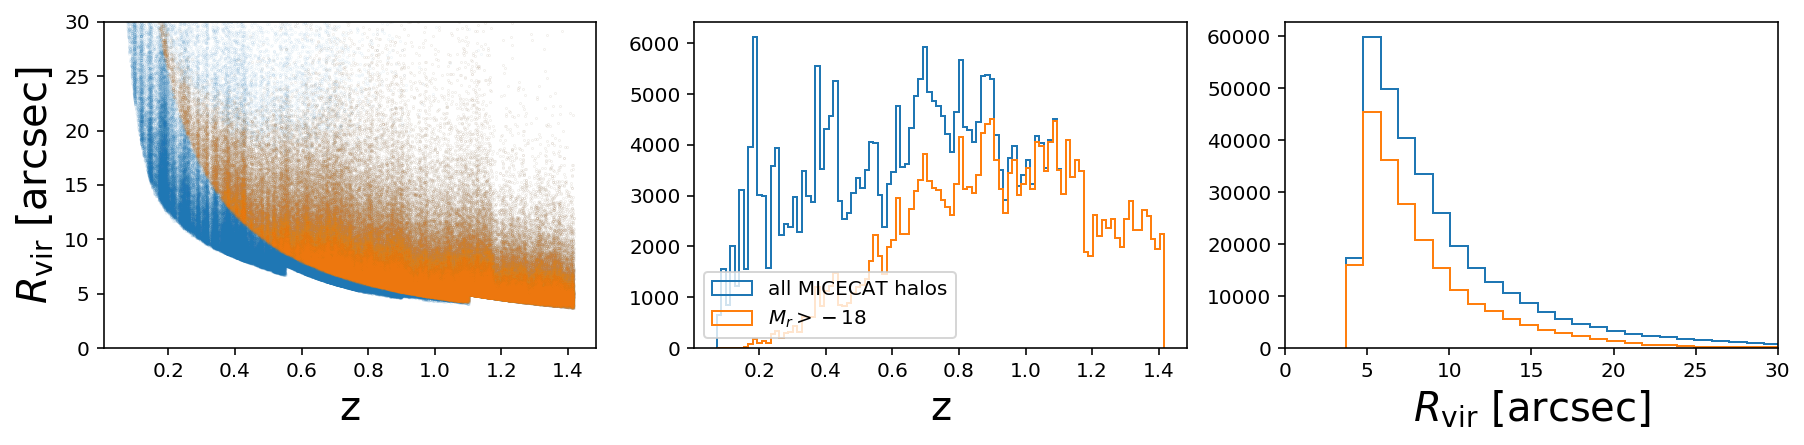

In [29]:
fig, ax = plt.subplots(1,3,figsize=(15,3))
ax[0].plot(df_all[df_all.flag_central==0].z_cgal, df_all[df_all.flag_central==0].Rv_arcsec,
           '.', markersize=0.05)
ax[0].plot(df[df.flag_central==0].z_cgal, df[df.flag_central==0].Rv_arcsec,
           '.', markersize=0.05)
ax[0].set_ylim([0,30])
ax[0].set_xlabel('z', fontsize=20)
ax[0].set_ylabel(r'$R_{\rm vir}$ [arcsec]', fontsize=20)

bins = ax[1].hist(df_all[df_all.flag_central==0].z_cgal,
                  bins=100, histtype='step', label='all MICECAT halos')
ax[1].hist(df[df.flag_central==0].z_cgal, 
           bins=bins[1], histtype='step', label=r'$M_r>-18$')
ax[1].legend(loc=3, fontsize=10)
ax[1].set_xlabel('z', fontsize=20)

bins = ax[2].hist(df_all[df_all.flag_central==0].Rv_arcsec, bins=500, histtype='step')
ax[2].hist(df[df.flag_central==0].Rv_arcsec, bins=bins[1], histtype='step')
ax[2].set_xlim([0,30])
ax[2].set_xlabel(r'$R_{\rm vir}$ [arcsec]', fontsize=20)

In [15]:
from micecat_field import *

# 1.1 um, 18 AB mag ~ 17 vega mag

# for m_th in [20,18,'-np.inf']:
#     ra_arr = np.arange(32,59,2)[::2]
#     dec_arr = np.arange(2,29,3)[::2]
#     dec_grid, ra_grid = np.meshgrid(dec_arr, ra_arr)
#     for ifield, (ra_cent, dec_cent) in enumerate(zip(ra_grid.flatten(), dec_grid.flatten())):
#         if ifield==0:
#             print("_ = run_IHL_Cl({}, {}, ihl_model='NFW', savemaps=True, m_th={})"\
#                   .format(ra_cent, dec_cent, m_th))
#         else:
#             print("_ = run_IHL_Cl({}, {}, ihl_model='NFW', savemaps=False, m_th={})"\
#                   .format(ra_cent, dec_cent, m_th))
#     print('')
    
#     if m_th==20:
#         for ifield, (ra_cent, dec_cent) in enumerate(zip(ra_grid.flatten(), dec_grid.flatten())):
#             if ifield==0:
#                 print("_ = run_IHL_Cl({}, {}, ihl_model='uniform_disk', savemaps=True, m_th={})"\
#                       .format(ra_cent, dec_cent, m_th))
#             else:
#                 print("_ = run_IHL_Cl({}, {}, ihl_model='uniform_disk', savemaps=False, m_th={})"\
#                       .format(ra_cent, dec_cent, m_th))
#         print('')
        
# for m_th in [20,18]:
#     ra_arr = np.arange(32,59,2)[::2]
#     dec_arr = np.arange(2,29,3)[::2]
#     dec_grid, ra_grid = np.meshgrid(dec_arr, ra_arr)
#     for ifield, (ra_cent, dec_cent) in enumerate(zip(ra_grid.flatten(), dec_grid.flatten())):
#         if ifield==0:
#             print("_ = run_IHL_Cl({}, {}, ihl_model='NFW', savemaps=True, m_th={}, mask_IHL = True)"\
#                   .format(ra_cent, dec_cent, m_th))
#         else:
#             print("_ = run_IHL_Cl({}, {}, ihl_model='NFW', savemaps=False, m_th={}, mask_IHL = True)"\
#                   .format(ra_cent, dec_cent, m_th))
#     print('')

***

Text(0.5, 1.0, 'IHL ($f_{\\rm IHL}$=1)')

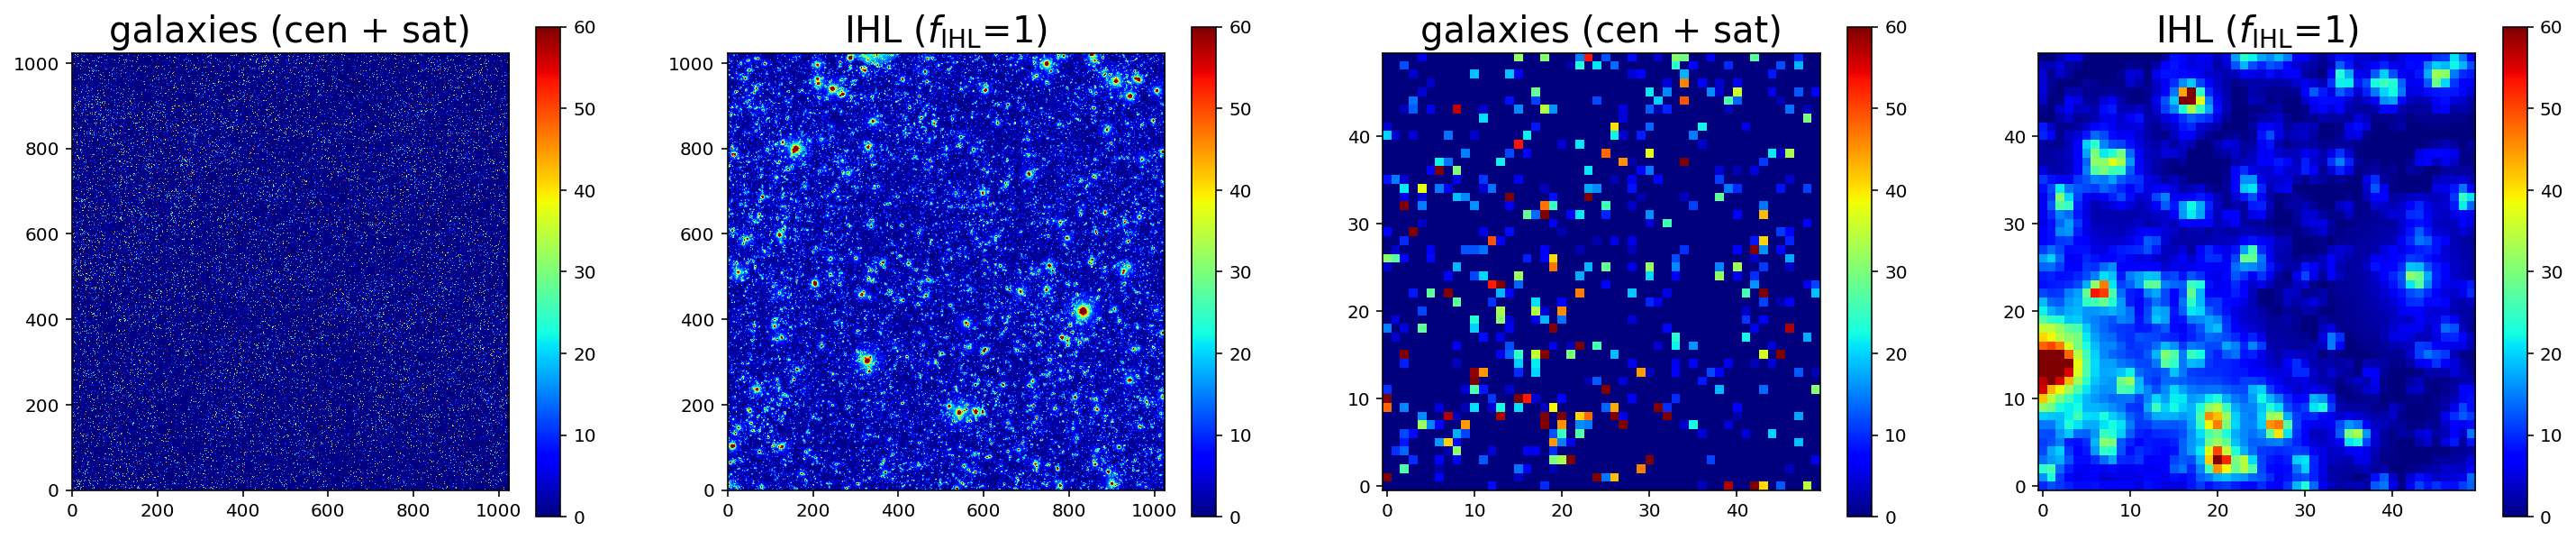

In [2]:
Cl_data = get_Cl_data(ihl_model='NFW', m_th = 20)
# Cl_data = get_Cl_data(ihl_model='uniform_disk', m_th = 20)

fig, ax = plt.subplots(1,4,figsize=(25,5))
imageclip(Cl_data['tot']['srcmap_cen']+Cl_data['tot']['srcmap_sat'], ax=ax[0], vmin=0, vmax=60)
imageclip(Cl_data['tot']['ihlmap'], ax=ax[1], vmin=0, vmax=60)
imageclip(Cl_data['tot']['srcmap_cen'][:50,:50]+Cl_data['tot']['srcmap_sat'][:50,:50],
          ax=ax[2], vmin=0, vmax=60)
imageclip(Cl_data['tot']['ihlmap'][:50,:50], ax=ax[3], vmin=0, vmax=60)
ax[0].set_title('galaxies (cen + sat)', fontsize=20)
ax[1].set_title(r'IHL ($f_{\rm IHL}$=1)', fontsize=20)
ax[2].set_title('galaxies (cen + sat)', fontsize=20)
ax[3].set_title(r'IHL ($f_{\rm IHL}$=1)', fontsize=20)

Text(0, 0.5, '$\\ell(\\ell+1)C_\\ell/2\\pi$\n$[nW^{2}m^{-4} sr^{-2}]$')

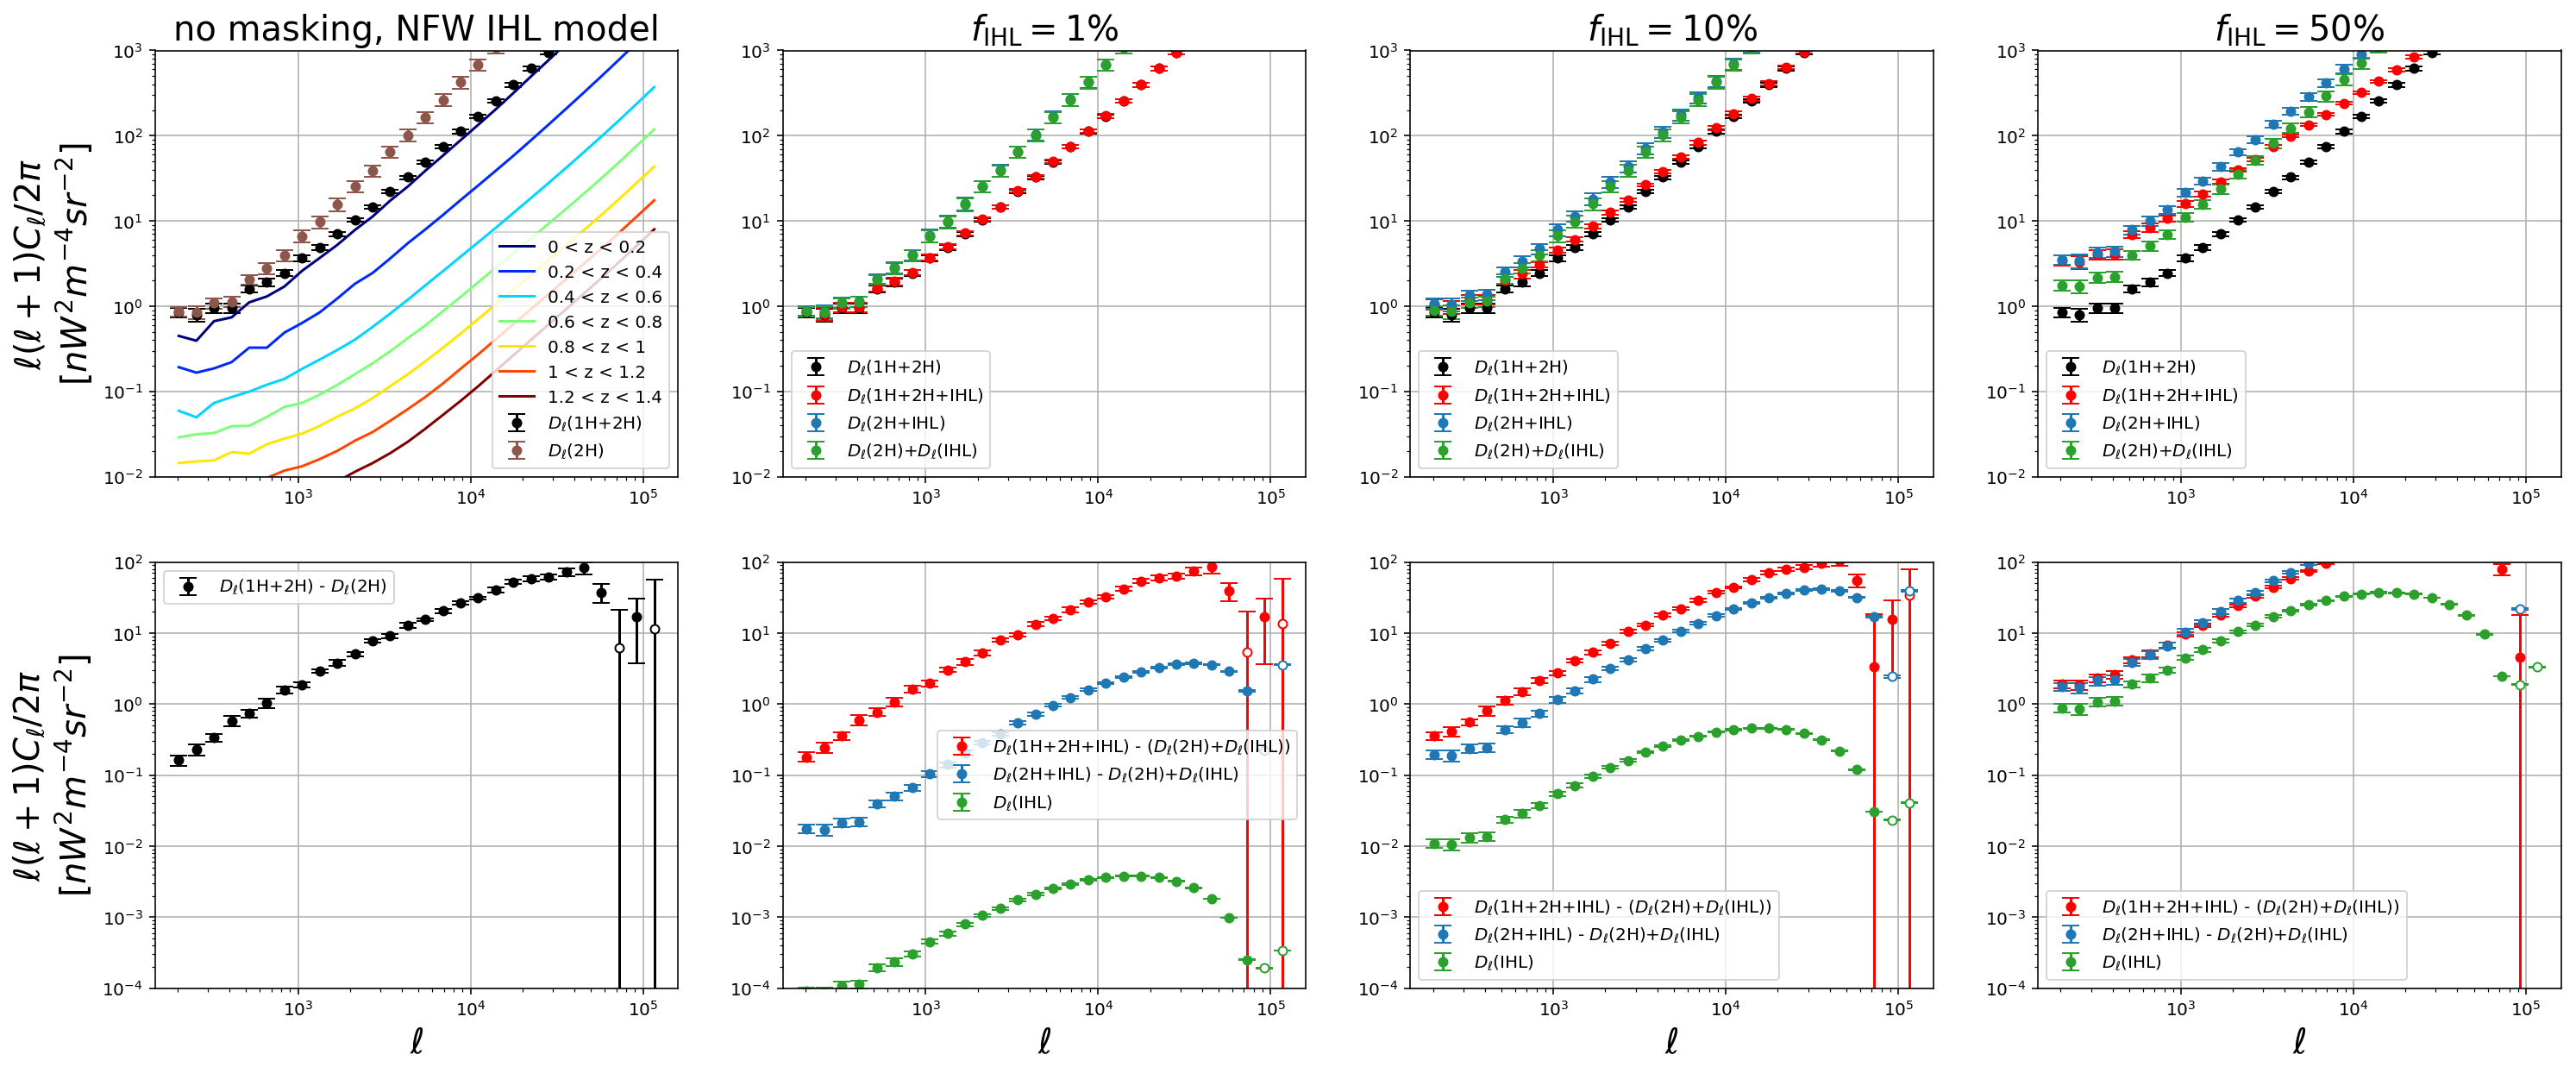

In [176]:
Cl_data = get_Cl_data(ihl_model='NFW', m_th = 20)

fig, ax = plt.subplots(2,4, figsize=(25,10))

l = Cl_data['l']
z_min_arr, z_max_arr = Cl_data['z_min_arr'], Cl_data['z_max_arr']

Nfields = len(Cl_data['tot']['Cla'])
Dla = l*(l+1)*Cl_data['tot']['Cla']/2/np.pi
Dl2 = l*(l+1)*Cl_data['tot']['Cl2']/2/np.pi
Dld = l*(l+1)*(Cl_data['tot']['Cla_shsub'] - Cl_data['tot']['Cl2_shsub'])/2/np.pi
Dla, Dlaerr = np.mean(Dla,axis=0), np.std(Dla, axis=0)/np.sqrt(Nfields)
Dl2, Dl2err = np.mean(Dl2,axis=0), np.std(Dl2, axis=0)/np.sqrt(Nfields)
Dld, Dlderr = np.mean(Dld,axis=0), np.std(Dld, axis=0)/np.sqrt(Nfields)
plot_err_log(l, Dla, Dlaerr, ax=ax[0][0], xlog=True, plot_xerr=False, 
                 color='k', capsize=5, markersize=10, 
             label=r'$D_\ell$(1H+2H)')
plot_err_log(l, Dl2, Dl2err, ax=ax[0][0], xlog=True, plot_xerr=False, 
                 color='C5', capsize=5, markersize=10, 
             label=r'$D_\ell$(2H)')
plot_err_log(l, Dld, Dlderr, ax=ax[1][0], xlog=True, plot_xerr=False, 
                 color='k', capsize=5, markersize=10, 
             label=r'$D_\ell$(1H+2H) - $D_\ell$(2H)')

for iz, (z_min, z_max) in enumerate(zip(z_min_arr, z_max_arr)):
    c = plt.cm.jet(np.linspace(0,1,len(z_min_arr)))[iz]
    Dla = l*(l+1)*Cl_data[iz]['Cla']/2/np.pi
    Dla, Dlaerr = np.mean(Dla,axis=0), np.std(Dla, axis=0)/np.sqrt(Nfields)
    ax[0][0].loglog(l, Dla, c=c, label='{} < z < {}'.format(z_min, z_max))
ax[0][0].legend()
ax[1][0].legend()
if m_th == -np.inf:
    ax[0][0].set_title(r'no masking, %s IHL model'\
                       %(Cl_data['ihl_model']), fontsize=20)
else:
    ax[0][0].set_title(r'mask $m_{1.1}$ = %d, %s IHL model'\
                       %(Cl_data['m_th'], Cl_data['ihl_model']), fontsize=20)

for if_IHL, f_IHL in enumerate([0.01,0.1,0.5]):
    r_IHL = f_IHL / (1 - f_IHL)
    
    Dla = l*(l+1)*Cl_data['tot']['Cla']/2/np.pi
    Dlah = l*(l+1)/2/np.pi*(Cl_data['tot']['Cla'] +\
                            r_IHL**2*Cl_data['tot']['Clh'] +\
                            2*r_IHL*Cl_data['tot']['Clha'])
    Dl2h = l*(l+1)/2/np.pi*(Cl_data['tot']['Cl2'] +\
                            r_IHL**2*Cl_data['tot']['Clh'] +\
                            2*r_IHL*Cl_data['tot']['Clh2'])
    Dl2hx = l*(l+1)/2/np.pi*(Cl_data['tot']['Cl2'] +\
                            r_IHL**2*Cl_data['tot']['Clh'])    
    Dla, Dlaerr = np.mean(Dla,axis=0), np.std(Dla, axis=0)/np.sqrt(Nfields)
    Dlah, Dlaherr = np.mean(Dlah,axis=0), np.std(Dlah, axis=0)/np.sqrt(Nfields)
    Dl2h, Dl2herr = np.mean(Dl2h,axis=0), np.std(Dl2h, axis=0)/np.sqrt(Nfields)
    Dl2hx, Dl2hxerr = np.mean(Dl2hx,axis=0), np.std(Dl2hx, axis=0)/np.sqrt(Nfields)
    
    plot_err_log(l, Dla, Dlaerr, ax=ax[0][if_IHL+1], xlog=True, plot_xerr=False, 
                     color='k', capsize=5, markersize=10, 
                 label=r'$D_\ell$(1H+2H)')
    plot_err_log(l, Dlah, Dlaherr, ax=ax[0][if_IHL+1], xlog=True, plot_xerr=False, 
                     color='r', capsize=5, markersize=10, 
                 label=r'$D_\ell$(1H+2H+IHL)')
    plot_err_log(l, Dl2h, Dl2herr, ax=ax[0][if_IHL+1], xlog=True, plot_xerr=False, 
                     color='C0', capsize=5, markersize=10, 
                 label=r'$D_\ell$(2H+IHL)')
    plot_err_log(l, Dl2hx, Dl2hxerr, ax=ax[0][if_IHL+1], xlog=True, plot_xerr=False, 
                    color='C2', capsize=5, markersize=10, 
                 label=r'$D_\ell$(2H)+$D_\ell$(IHL)')
    ax[0][if_IHL+1].legend()
    
    Dlh = l*(l+1)*r_IHL**2*Cl_data['tot']['Clh_shsub']/2/np.pi
    Dlah = l*(l+1)/2/np.pi*(Cl_data['tot']['Cla_shsub'] +\
                            r_IHL**2*Cl_data['tot']['Clh_shsub'] +\
                            2*r_IHL*Cl_data['tot']['Clha_shsub'])
    Dl2h = l*(l+1)/2/np.pi*(Cl_data['tot']['Cl2_shsub'] +\
                            r_IHL**2*Cl_data['tot']['Clh_shsub'] +\
                            2*r_IHL*Cl_data['tot']['Clh2_shsub'])
    Dl2hx = l*(l+1)/2/np.pi*(Cl_data['tot']['Cl2_shsub'] +\
                            r_IHL**2*Cl_data['tot']['Clh_shsub'])
    Dlahd = Dlah - Dl2hx
    Dl2hd = Dl2h - Dl2hx    
    Dlh, Dlherr = np.mean(Dlh,axis=0), np.std(Dlh, axis=0)/np.sqrt(Nfields)
    Dlahd, Dlahderr = np.mean(Dlahd,axis=0), np.std(Dlahd, axis=0)/np.sqrt(Nfields)
    Dl2hd, Dl2hderr = np.mean(Dl2hd,axis=0), np.std(Dl2hd, axis=0)/np.sqrt(Nfields)
    
    plot_err_log(l, Dlahd, Dlahderr, ax=ax[1][if_IHL+1], xlog=True, plot_xerr=False, 
                     color='r', capsize=5, markersize=10, 
                 label=r'$D_\ell$(1H+2H+IHL) - ($D_\ell$(2H)+$D_\ell$(IHL))')
    plot_err_log(l, Dl2hd, Dl2hderr, ax=ax[1][if_IHL+1], xlog=True, plot_xerr=False, 
                     color='C0', capsize=5, markersize=10, 
                 label=r'$D_\ell$(2H+IHL) - $D_\ell$(2H)+$D_\ell$(IHL)')
    plot_err_log(l, Dlh, Dlherr, ax=ax[1][if_IHL+1], xlog=True, plot_xerr=False, 
                     color='C2', capsize=5, markersize=10, 
                 label=r'$D_\ell$(IHL)')
    
    ax[1][if_IHL+1].legend()   
    ax[0][if_IHL+1].set_title(r'$f_{\rm IHL}=$'+ '{:.0%}'.format(f_IHL), fontsize=20)
    ax[1][if_IHL+1].set_xlabel(r'$\ell$', fontsize=20)
    ax[0][if_IHL+1].grid()
    ax[1][if_IHL+1].grid()
    ax[0][if_IHL+1].set_ylim([1e-2,1e3])
    ax[1][if_IHL+1].set_ylim([1e-4,1e2])

ax[0][0].grid()
ax[1][0].grid()
ax[0][0].set_ylim([1e-2,1e3])
ax[1][0].set_ylim([1e-4,1e2])
ax[1][0].set_xlabel(r'$\ell$', fontsize=20)
ax[0][0].set_ylabel(r'$\ell(\ell+1)C_\ell/2\pi$'+'\n'+r'$[nW^{2}m^{-4} sr^{-2}]$',
                     fontsize=20)
ax[1][0].set_ylabel(r'$\ell(\ell+1)C_\ell/2\pi$'+'\n'+r'$[nW^{2}m^{-4} sr^{-2}]$',
                     fontsize=20)

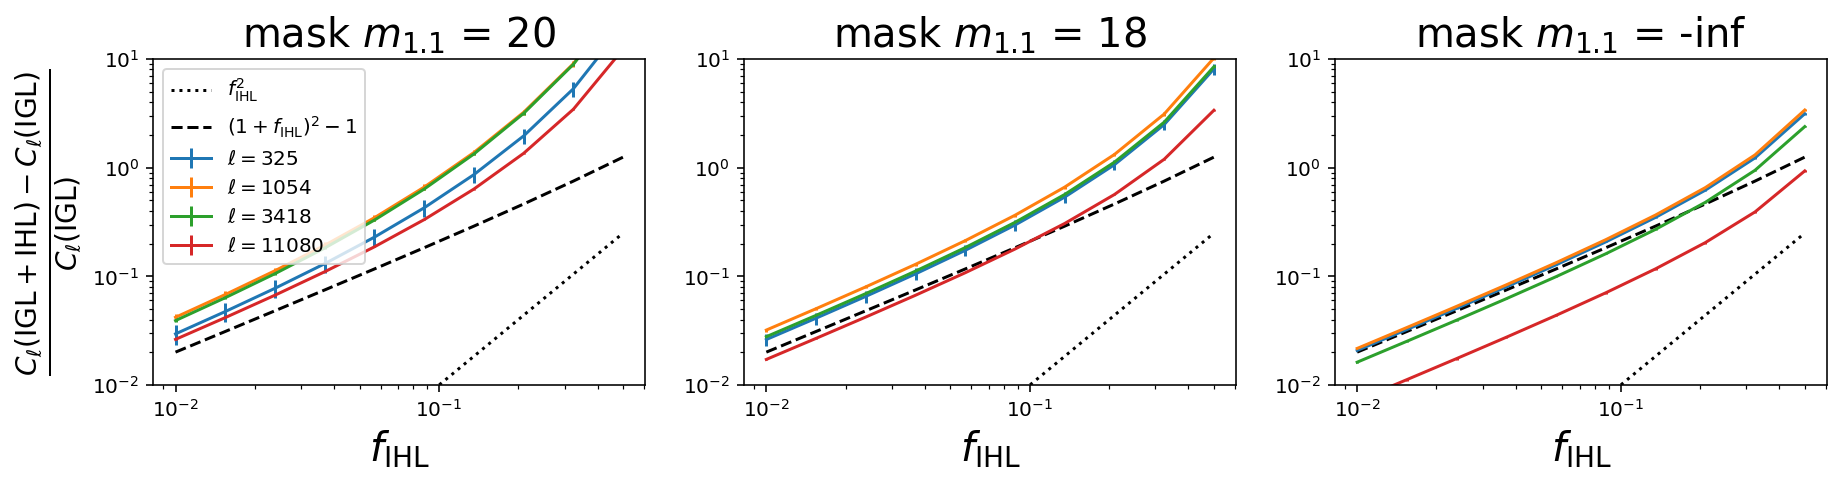

In [22]:
fig, ax = plt.subplots(1,3, figsize=(15,3))

for im, m_th in enumerate([20,18,-np.inf]):
    Cl_data = get_Cl_data(ihl_model='NFW', m_th=m_th)
    l = Cl_data['l']
    z_min_arr, z_max_arr = Cl_data['z_min_arr'], Cl_data['z_max_arr']
    Nfields = len(Cl_data['tot']['Cla'])

    f_IHL_arr = np.logspace(-2,np.log10(0.5),10)
    il_arr = [2,7,12,17]
    r_arr = np.zeros((len(il_arr),len(f_IHL_arr)))
    r_err = np.zeros((len(il_arr),len(f_IHL_arr)))

    for if_IHL, f_IHL in enumerate(f_IHL_arr):
        r_IHL = f_IHL / (1 - f_IHL)

        Dla = l*(l+1)*Cl_data['tot']['Cla']/2/np.pi
        Dlah = l*(l+1)/2/np.pi*(Cl_data['tot']['Cla'] +\
                                r_IHL**2*Cl_data['tot']['Clh'] +\
                                2*r_IHL*Cl_data['tot']['Clha'])

        Dlr = (Dlah - Dla)/Dla
        Dla, Dlaerr = np.mean(Dla,axis=0), np.std(Dla, axis=0)/np.sqrt(Nfields)
        Dlah, Dlaherr = np.mean(Dlah,axis=0), np.std(Dlah, axis=0)/np.sqrt(Nfields)
        Dlr, Dlrerr = np.mean(Dlr,axis=0), np.std(Dlr, axis=0)/np.sqrt(Nfields)

        r_arr[:,if_IHL] = Dlr[il_arr]
        r_err[:,if_IHL] = Dlrerr[il_arr]

    for i,il in enumerate(il_arr):
        c = 'C'+str(i)#plt.cm.jet(np.linspace(0.5,1,len(il_arr)))[i]
        ax[im].errorbar(f_IHL_arr,r_arr[i], r_err[i], c=c, label=r'$\ell=$%d'%(l[il]))
    
    ax[im].plot(f_IHL_arr, f_IHL_arr**2, 'k:', label=r'$f_{\rm IHL}^2$')
    ax[im].plot(f_IHL_arr, (1+f_IHL_arr)**2-1, 'k--', label=r'$(1+f_{\rm IHL})^2-1$')
    
    ax[0].legend()
    ax[im].set_xscale('log')
    ax[im].set_yscale('log')
    ax[im].set_xlabel(r'$f_{\rm IHL}$', fontsize=20)
    ax[0].set_ylabel(r'$\frac{C_\ell({\rm IGL+IHL})-C_\ell({\rm IGL})}{C_\ell({\rm IGL})}$',fontsize=20)
    ax[im].set_ylim([1e-2,1e1])
    ax[im].set_title(r'mask $m_{1.1}$ ='+' {}'.format(m_th), fontsize=20)

***

Text(0, 0.5, '$\\ell(\\ell+1)C_\\ell/2\\pi$\n$[nW^{2}m^{-4} sr^{-2}]$')

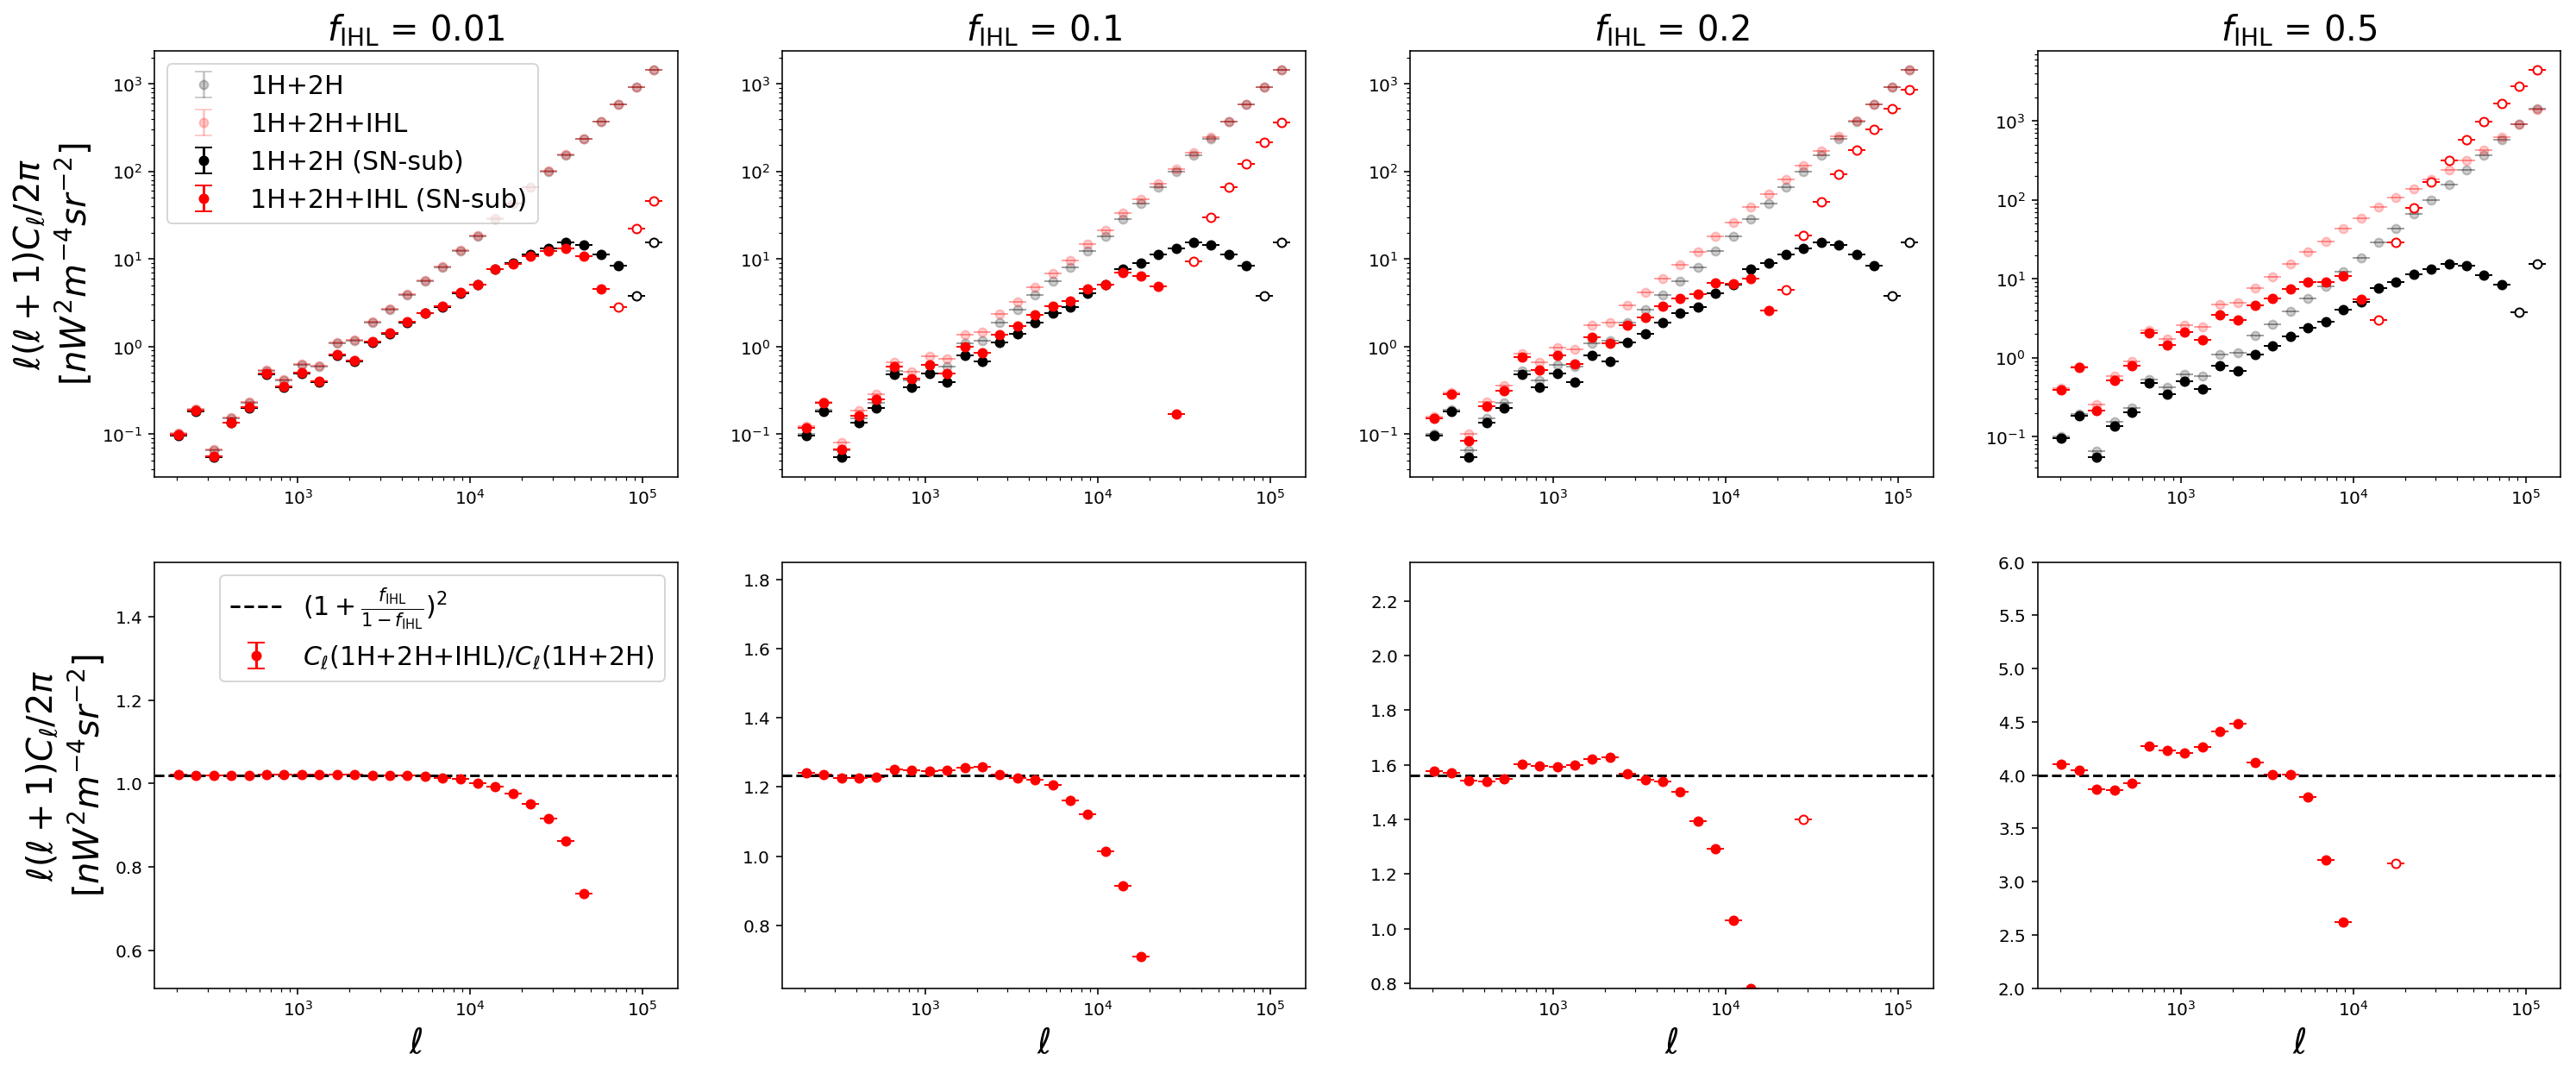

In [56]:
# from micecat_field import *
# # Cl_data = get_Cl_data(ihl_model='NFW', m_th=-np.inf)
# # Cl_data = get_Cl_data(ihl_model='NFW', m_th=20)
# Cl_data = get_Cl_data(ihl_model='NFW', m_th=18)

# f_IHL_arr = [0.01, 0.1, 0.2, 0.5]
# fig, ax = plt.subplots(2,4,figsize=(25,10))
# for i, f_IHL in enumerate(f_IHL_arr):
#     r_IHL = f_IHL / (1 - f_IHL)
#     l = Cl_data['l']
#     Nfields = len(Cl_data['tot']['Cla'])

#     Cla = Cl_data['tot']['Cla'].copy()
#     Cla_arr = np.median(Cla,axis=0) 
#     Cla_err = (np.percentile(Cla,16,axis=0) - np.percentile(Cla,84,axis=0))/2/np.sqrt(Nfields)
#     plot_err_log(l, l*(l+1)/2/np.pi*Cla_arr, l*(l+1)/2/np.pi*Cla_err, ax=ax[0][i],
#                  xlog=True, plot_xerr=False, color='k', capsize=5, markersize=10,
#                  alpha=0.2,label=r'1H+2H')

#     Clah = (Cl_data['tot']['Cla'] +\
#                             r_IHL**2*Cl_data['tot']['Clh'] +\
#                             2*r_IHL*Cl_data['tot']['Clha'])
#     Clah_arr= np.median(Clah,axis=0)
#     Clah_err  = (np.percentile(Clah,16,axis=0) - np.percentile(Clah,84,axis=0))/2/np.sqrt(Nfields)
#     plot_err_log(l, l*(l+1)/2/np.pi*Clah_arr, l*(l+1)/2/np.pi*Clah_err, ax=ax[0][i],
#                  xlog=True, plot_xerr=False, color='r', capsize=5, markersize=10, 
#                  alpha=0.2,label=r'1H+2H+IHL')

#     Clsh = np.tile(np.mean(Cla[:,-3:],axis=1),(len(l),1)).T
#     Cla -= Clsh
#     Cla_arr = np.median(Cla,axis=0) 
#     Cla_err = (np.percentile(Cla,16,axis=0) - np.percentile(Cla,84,axis=0))/2/np.sqrt(Nfields)
#     plot_err_log(l, l*(l+1)/2/np.pi*Cla_arr, l*(l+1)/2/np.pi*Cla_err, ax=ax[0][i],
#                  xlog=True, plot_xerr=False, color='k', capsize=5, markersize=10, 
#                  label=r'1H+2H (SN-sub)')

#     # Clsh = np.tile(np.mean(Clah[:,-3:],axis=1),(len(l),1)).T
#     Clsh = Clsh * (1+r_IHL)**2
#     Clah -= Clsh
#     Clah_arr= np.median(Clah,axis=0) 
#     Clah_err  = (np.percentile(Clah,16,axis=0) - np.percentile(Clah,84,axis=0))/2/np.sqrt(Nfields)
#     plot_err_log(l, l*(l+1)/2/np.pi*Clah_arr, l*(l+1)/2/np.pi*Clah_err, ax=ax[0][i],
#                  xlog=True, plot_xerr=False, color='r', capsize=5, markersize=10, 
#                  label=r'1H+2H+IHL (SN-sub)')

#     r_arr = np.median(Clah/Cla,axis=0)
#     r_err = (np.percentile(Clah/Cla,16,axis=0) - np.percentile(Clah/Cla,84,axis=0))/2/np.sqrt(Nfields)
#     plot_err_log(l, r_arr, r_err, ax=ax[1][i],
#                  xlog=True, plot_xerr=False, color='r', capsize=5, markersize=10, 
#                  label=r'$C_\ell$(1H+2H+IHL)/$C_\ell$(1H+2H)')
#     ax[1][i].set_yscale('linear')
#     ax[1][i].axhline((1+r_IHL)**2,c='k',ls='--', label=r'$(1+\frac{f_{\rm IHL}}{1-f_{\rm IHL}})^2$')
#     ax[1][i].set_ylim([(1+r_IHL)**2*0.5,(1+r_IHL)**2*1.5])
#     ax[0][0].legend(fontsize=15)
#     ax[1][0].legend(fontsize=15)
#     ax[0][i].set_title(r'$f_{\rm IHL}$ = ' + '{}'.format(f_IHL), fontsize=20)
#     ax[1][i].set_xlabel(r'$\ell$', fontsize=20)
# ax[0][0].set_ylabel(r'$\ell(\ell+1)C_\ell/2\pi$'+'\n'+r'$[nW^{2}m^{-4} sr^{-2}]$',
#                      fontsize=20)
# ax[1][0].set_ylabel(r'$\ell(\ell+1)C_\ell/2\pi$'+'\n'+r'$[nW^{2}m^{-4} sr^{-2}]$',
#                      fontsize=20)

Text(0, 0.5, '$\\ell(\\ell+1)C_\\ell/2\\pi$\n$[nW^{2}m^{-4} sr^{-2}]$')

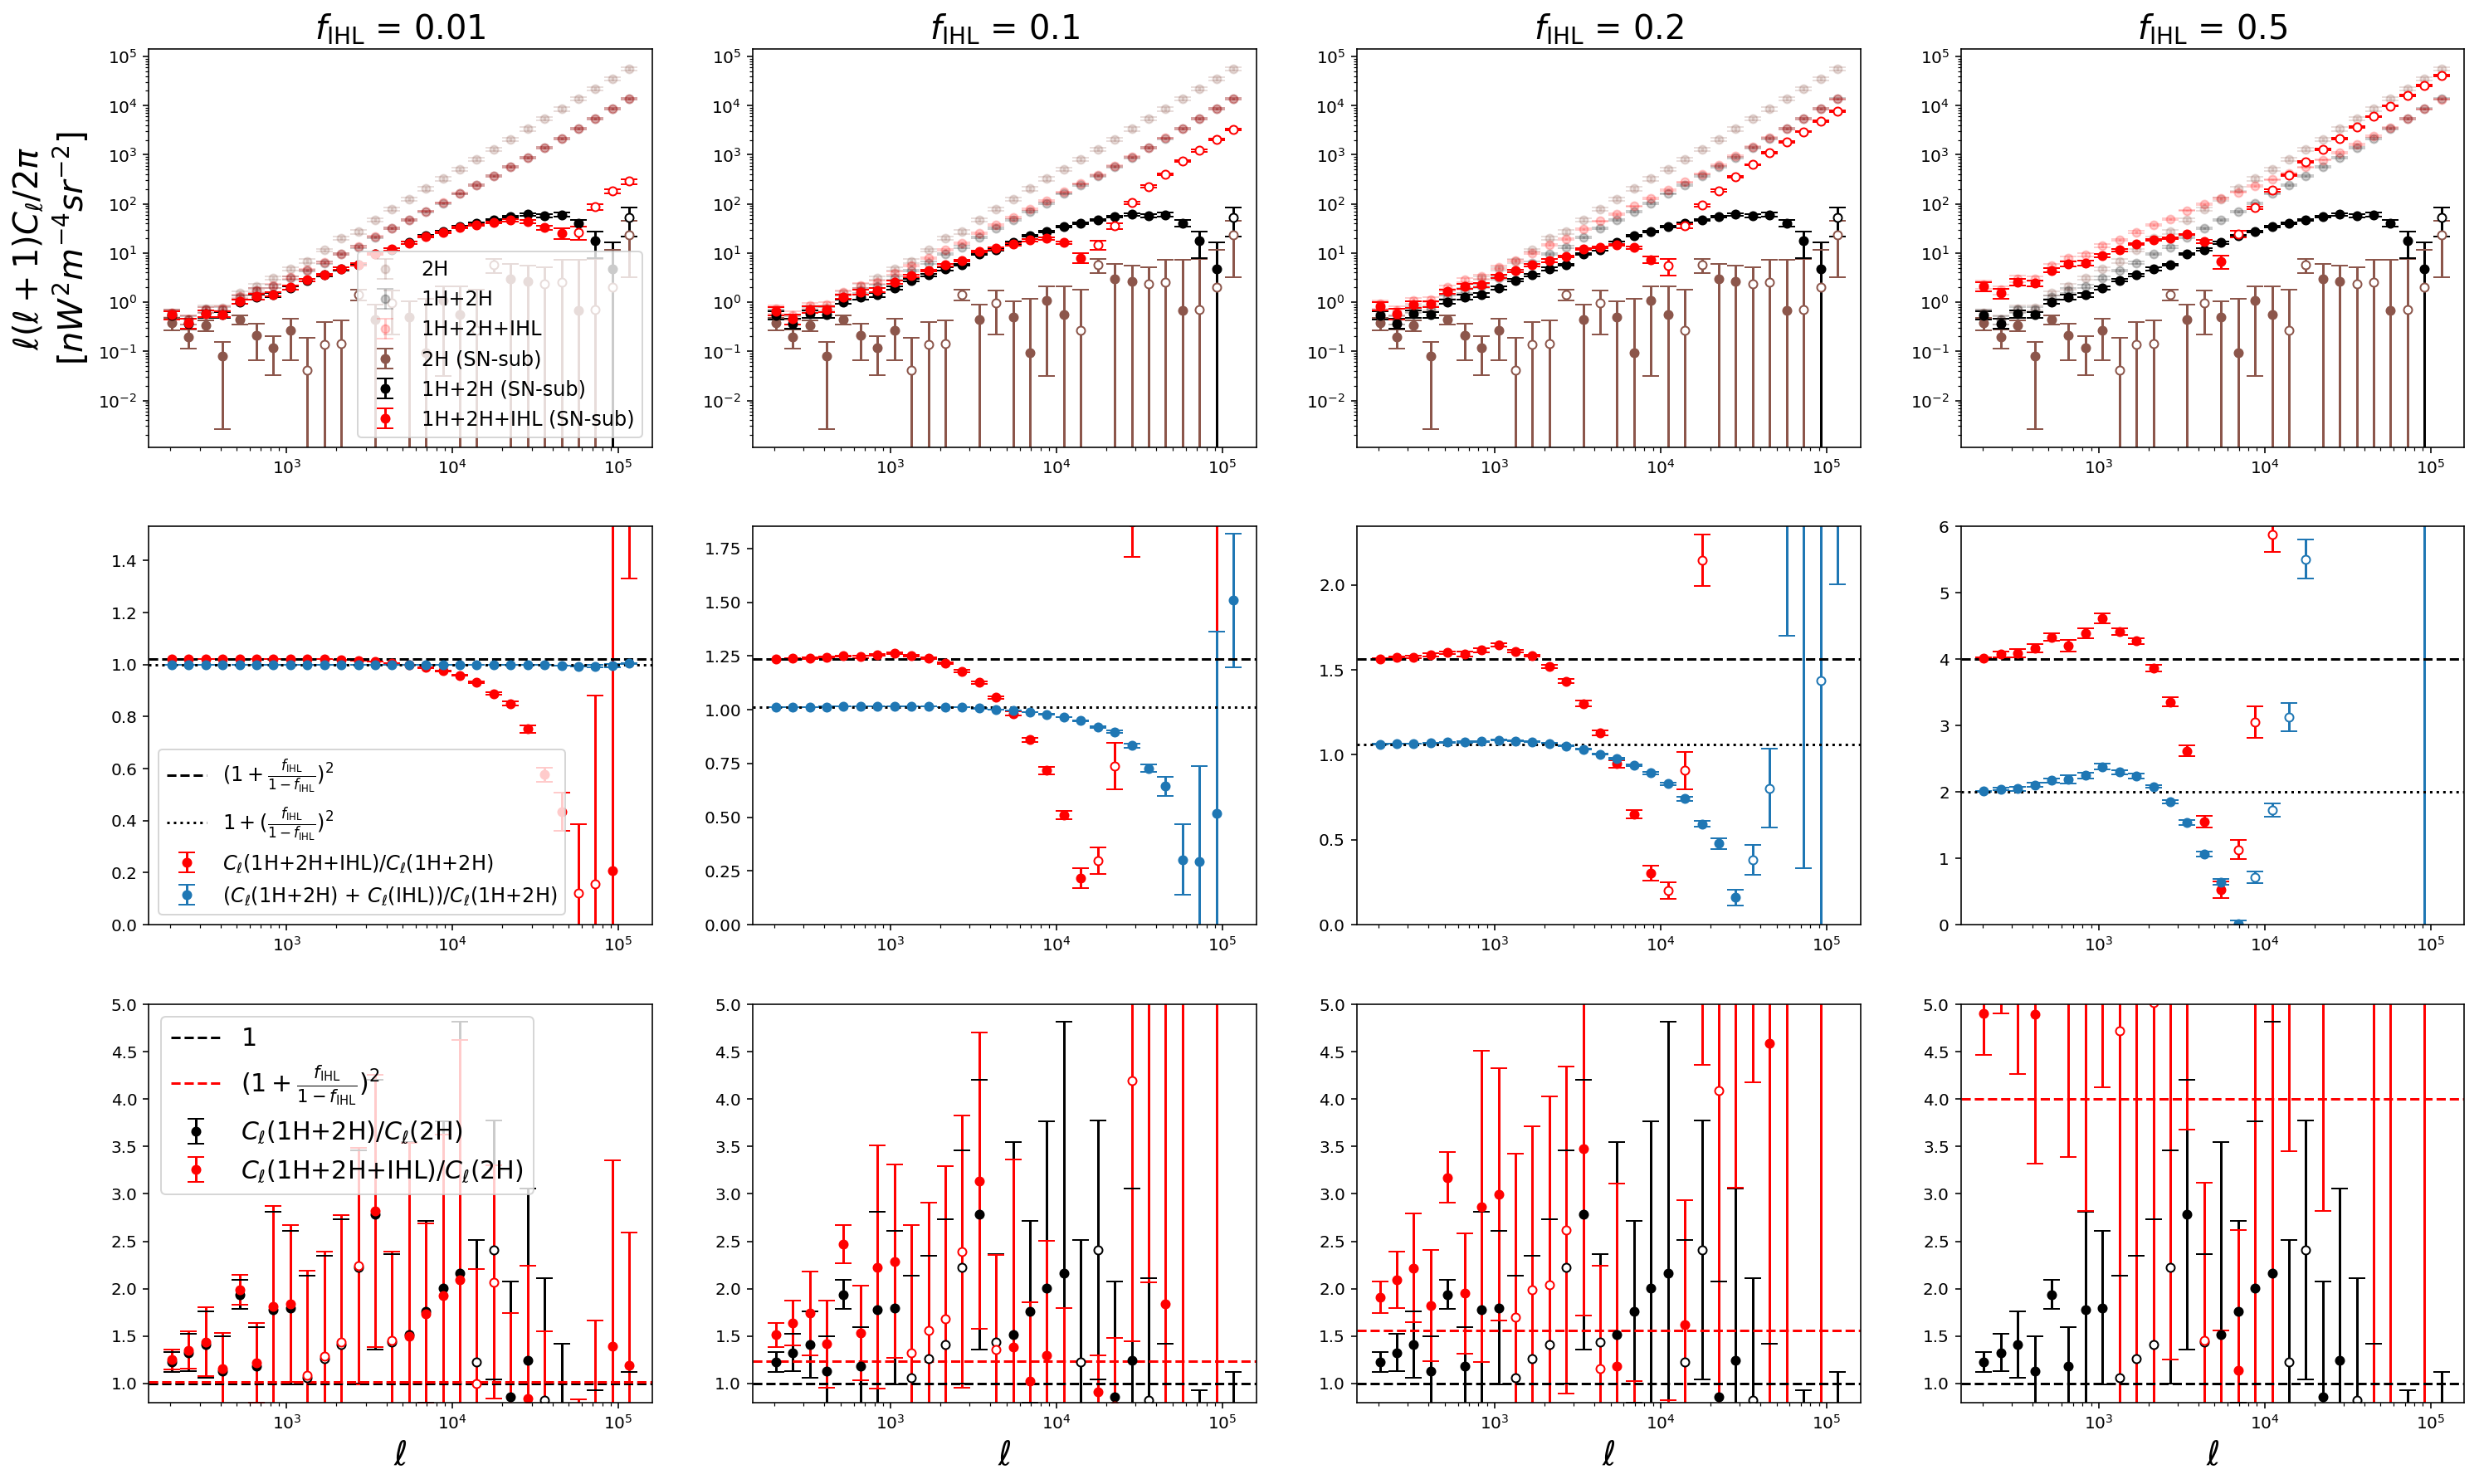

In [4]:
from micecat_field import *
Cl_data = get_Cl_data(ihl_model='NFW', m_th=-np.inf)
# Cl_data = get_Cl_data(ihl_model='NFW', m_th=18)
# Cl_data = get_Cl_data(ihl_model='NFW', m_th=20)

f_IHL_arr = [0.01, 0.1, 0.2, 0.5]
fig, ax = plt.subplots(3,4,figsize=(25,15))
for i, f_IHL in enumerate(f_IHL_arr):
    r_IHL = f_IHL / (1 - f_IHL)
    l = Cl_data['l']
    Nfields = len(Cl_data['tot']['Cla'])

    Cl2 = Cl_data['tot']['Cl2'].copy()
    Cl2_arr = np.median(Cl2,axis=0) 
    Cl2_err = (np.percentile(Cl2,84,axis=0) - np.percentile(Cl2,16,axis=0))/2/np.sqrt(Nfields)
    plot_err_log(l, l*(l+1)/2/np.pi*Cl2_arr, l*(l+1)/2/np.pi*Cl2_err, ax=ax[0][i],
                 xlog=True, plot_xerr=False, color='C5', capsize=5, markersize=10,
                 alpha=0.2,label=r'2H')

    Cla = Cl_data['tot']['Cla'].copy()
    Cla_arr = np.median(Cla,axis=0) 
    Cla_err = (np.percentile(Cla,84,axis=0) - np.percentile(Cla,16,axis=0))/2/np.sqrt(Nfields)
    plot_err_log(l, l*(l+1)/2/np.pi*Cla_arr, l*(l+1)/2/np.pi*Cla_err, ax=ax[0][i],
                 xlog=True, plot_xerr=False, color='k', capsize=5, markersize=10,
                 alpha=0.2,label=r'1H+2H')

    Clah = (Cl_data['tot']['Cla'] +\
                            r_IHL**2*Cl_data['tot']['Clh'] +\
                            2*r_IHL*Cl_data['tot']['Clha'])
    Clah_arr= np.median(Clah,axis=0)
    Clah_err  = (np.percentile(Clah,84,axis=0) - np.percentile(Clah,16,axis=0))/2/np.sqrt(Nfields)
    plot_err_log(l, l*(l+1)/2/np.pi*Clah_arr, l*(l+1)/2/np.pi*Clah_err, ax=ax[0][i],
                 xlog=True, plot_xerr=False, color='r', capsize=5, markersize=10, 
                 alpha=0.2,label=r'1H+2H+IHL')
    
    # ===================
    Clsh2 = np.tile(np.mean(Cl2[:,-3:],axis=1),(len(l),1)).T
    Cl2 -= Clsh2
    Cl2_arr = np.median(Cl2,axis=0) 
    Cl2_err = (np.percentile(Cl2,84,axis=0) - np.percentile(Cl2,16,axis=0))/2/np.sqrt(Nfields)
    plot_err_log(l, l*(l+1)/2/np.pi*Cl2_arr, l*(l+1)/2/np.pi*Cl2_err, ax=ax[0][i],
                 xlog=True, plot_xerr=False, color='C5', capsize=5, markersize=10, 
                 label=r'2H (SN-sub)')

    Clsha = np.tile(np.mean(Cla[:,-3:],axis=1),(len(l),1)).T
    Cla -= Clsha
    Cla_arr = np.median(Cla,axis=0) 
    Cla_err = (np.percentile(Cla,84,axis=0) - np.percentile(Cla,16,axis=0))/2/np.sqrt(Nfields)
    plot_err_log(l, l*(l+1)/2/np.pi*Cla_arr, l*(l+1)/2/np.pi*Cla_err, ax=ax[0][i],
                 xlog=True, plot_xerr=False, color='k', capsize=5, markersize=10, 
                 label=r'1H+2H (SN-sub)')

    Clshh = Clsha * (1+r_IHL)**2
    Clah -= Clshh
    Clah_arr= np.median(Clah,axis=0) 
    Clah_err  = (np.percentile(Clah,84,axis=0) - np.percentile(Clah,16,axis=0))/2/np.sqrt(Nfields)
    plot_err_log(l, l*(l+1)/2/np.pi*Clah_arr, l*(l+1)/2/np.pi*Clah_err, ax=ax[0][i],
                 xlog=True, plot_xerr=False, color='r', capsize=5, markersize=10, 
                 label=r'1H+2H+IHL (SN-sub)')

    ax[0][0].legend(fontsize=12)
    ax[0][i].set_title(r'$f_{\rm IHL}$ = ' + '{}'.format(f_IHL), fontsize=20)
    
    # ==============
    r_arr = np.median(Clah/Cla,axis=0)
    r_err = (np.percentile(Clah/Cla,16,axis=0) - np.percentile(Clah/Cla,84,axis=0))/2/np.sqrt(Nfields)
    plot_err_log(l, r_arr, r_err, ax=ax[1][i],
                 xlog=True, plot_xerr=False, color='r', capsize=5, markersize=10, 
                 label=r'$C_\ell$(1H+2H+IHL)/$C_\ell$(1H+2H)')
    Clh = r_IHL**2*Cl_data['tot']['Clh'].copy()
    Clh -= (Clsha * r_IHL**2)
    r_arr = np.median(Clh/Cla,axis=0) + 1
    r_err = (np.percentile(Clh/Cla,16,axis=0) - np.percentile(Clh/Cla,84,axis=0))/2/np.sqrt(Nfields)
    plot_err_log(l, r_arr, r_err, ax=ax[1][i],
                 xlog=True, plot_xerr=False, color='C0', capsize=5, markersize=10,
                 label=r'($C_\ell$(1H+2H) + $C_\ell$(IHL))/$C_\ell$(1H+2H)')
    ax[1][i].set_yscale('linear')
    ax[1][i].axhline((1+r_IHL)**2,c='k',ls='--', label=r'$(1+\frac{f_{\rm IHL}}{1-f_{\rm IHL}})^2$')
    ax[1][i].axhline(1+r_IHL**2,c='k',ls=':', label=r'$1+(\frac{f_{\rm IHL}}{1-f_{\rm IHL}})^2$')
    ax[1][i].set_ylim([0,(1+r_IHL)**2*1.5])
    ax[1][0].legend(fontsize=12)

    r_arr = np.median(Cla/Cl2,axis=0)
    r_err = (np.percentile(Cla/Cl2,84,axis=0) - np.percentile(Cla/Cl2,16,axis=0))/2/np.sqrt(Nfields)
    plot_err_log(l, r_arr, r_err, ax=ax[2][i],
                 xlog=True, plot_xerr=False, color='k', capsize=5, markersize=10, 
                 label=r'$C_\ell$(1H+2H)/$C_\ell$(2H)')

    r_arr = np.median(Clah/Cl2,axis=0)
    r_err = (np.percentile(Clah/Cl2,84,axis=0) - np.percentile(Clah/Cl2,16,axis=0))/2/np.sqrt(Nfields)
    plot_err_log(l, r_arr, r_err, ax=ax[2][i],
                 xlog=True, plot_xerr=False, color='r', capsize=5, markersize=10, 
                 label=r'$C_\ell$(1H+2H+IHL)/$C_\ell$(2H)')
    ax[2][i].set_yscale('linear')
    ax[2][i].axhline(1,c='k',ls='--', label=r'$1$')
    ax[2][i].axhline((1+r_IHL)**2,c='r',ls='--', label=r'$(1+\frac{f_{\rm IHL}}{1-f_{\rm IHL}})^2$')
    ax[2][i].set_ylim([0.8,5])
    ax[2][0].legend(fontsize=15)
    ax[2][i].set_xlabel(r'$\ell$', fontsize=20)

ax[0][0].set_ylabel(r'$\ell(\ell+1)C_\ell/2\pi$'+'\n'+r'$[nW^{2}m^{-4} sr^{-2}]$',
                     fontsize=20)

***

In [1]:
from micecat_field import *

ra_cent, dec_cent = 32, 2
abs_mag_cut = -18
m_th = 18
bandname = 'ciber_I'

fname = mypaths['ciberdir']+'python_ciber/stack_modelfit/micecat_IHL_data/'\
+'micecat_IHL_Cl_data_ra{}_dec{}_{}_mth{}_maskIHL.pkl'\
.format(ra_cent, dec_cent, 'NFW', m_th)
with open(fname, "rb") as f:
    Cl_data = pickle.load(f)

mcfield = micecat_field(ra_cent, dec_cent,Nx=1024,Ny=1024)
df = mcfield.get_micecat_df(add_fields=['sdss_r_abs_mag'])
df = df[df.sdss_r_abs_mag <= abs_mag_cut]
df_masked = df[df[bandname+'_true'] > m_th]

In [2]:
srcmapf = Cl_data['tot']['srcmap_cen'].copy()+Cl_data['tot']['srcmap_sat'].copy()
srcmapf_2h = Cl_data['tot']['srcmap_allcen'].copy()
ihlmap = Cl_data['tot']['ihlmap'].copy()
srcmap_psf = mcfield.make_map(bandname, df=df, PSF_func='Gaussian',
                          PSF_m_max=m_th, PSF_Gaussian_sig=10,verbose=True)
mask = mcfield.make_mask(bandname, df=df, m_th=m_th)[0]
mkk = mask_Mkk(mask)
mkk.get_Mkk_sim(verbose=True)
clear_output()

Text(0, 0.5, '$C_\\ell/C_\\ell$(1H+2H)')

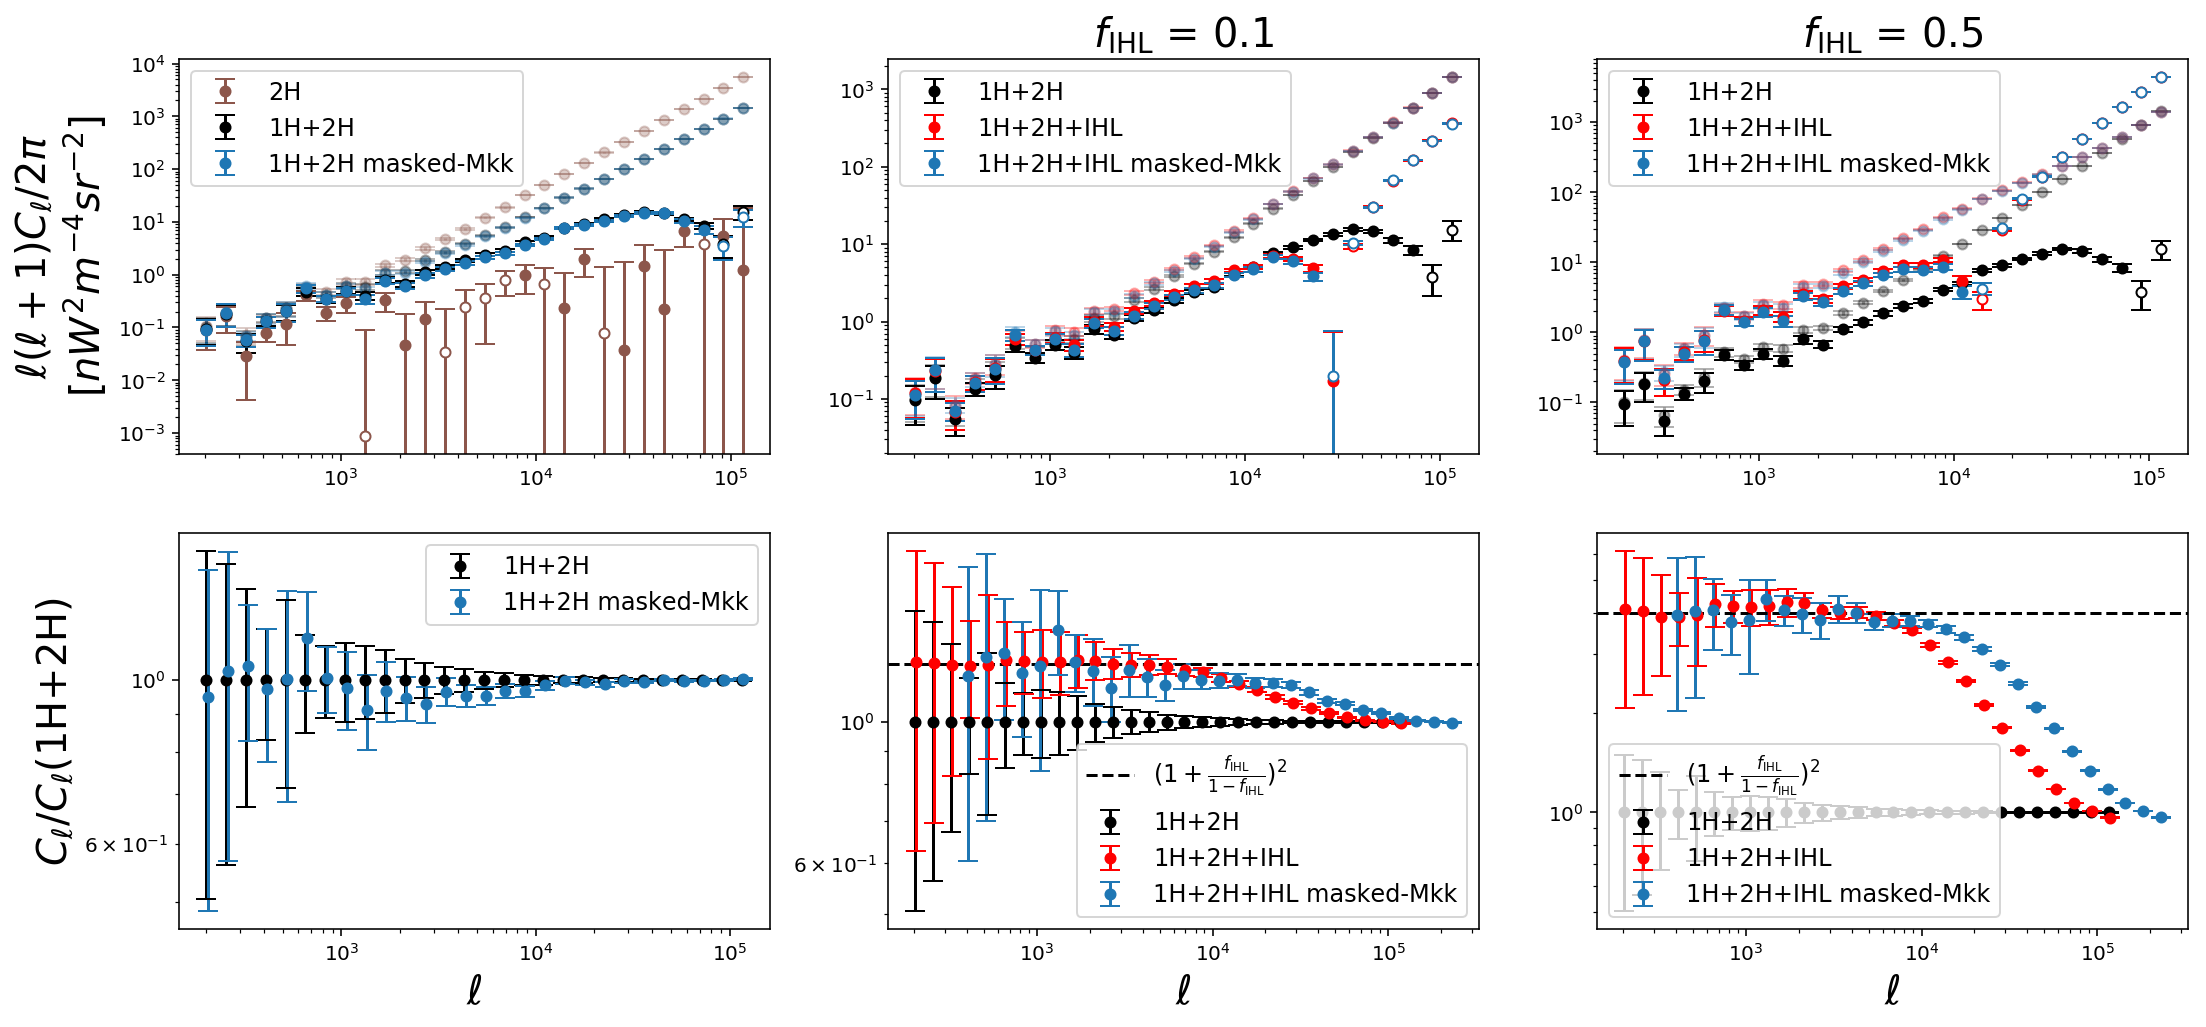

In [3]:
fig, ax = plt.subplots(2,3,figsize=(18,8))

l,Cla, Cla_err = get_power_spec(srcmapf)
l,Cl2, Cl2_err = get_power_spec(srcmapf_2h)
l,Clam, Clam_err = get_power_spec(srcmap_psf, mask=mask)
Clam, Clam_err = mkk.Mkk_correction(Clam, Clerr=Clam_err)

Cla_shsub = Cla - np.mean(Cla[-3:])
Cl2_shsub = Cl2 - np.mean(Cl2[-3:])
Clam_shsub = Clam - np.mean(Clam[-3:])

plot_err_log(l, l*(l+1)/2/np.pi*Cl2, l*(l+1)/2/np.pi*Cl2_err, ax=ax[0][0],
             xlog=True, plot_xerr=False, color='C5', capsize=5, markersize=10, 
             alpha=0.3)

plot_err_log(l, l*(l+1)/2/np.pi*Cla, l*(l+1)/2/np.pi*Cla_err, ax=ax[0][0],
             xlog=True, plot_xerr=False, color='k', capsize=5, markersize=10, 
             alpha=0.3)

plot_err_log(l, l*(l+1)/2/np.pi*Clam, l*(l+1)/2/np.pi*Clam_err, ax=ax[0][0],
             xlog=True, plot_xerr=False, color='C0', capsize=5, markersize=10, 
             alpha=0.3)

plot_err_log(l, l*(l+1)/2/np.pi*Cl2_shsub, l*(l+1)/2/np.pi*Cl2_err, ax=ax[0][0],
             xlog=True, plot_xerr=False, color='C5', capsize=5, markersize=10, 
             alpha=1, label=r'2H')

plot_err_log(l, l*(l+1)/2/np.pi*Cla_shsub, l*(l+1)/2/np.pi*Cla_err, ax=ax[0][0],
             xlog=True, plot_xerr=False, color='k', capsize=5, markersize=10, 
             alpha=1, label=r'1H+2H')

plot_err_log(l, l*(l+1)/2/np.pi*Clam_shsub, l*(l+1)/2/np.pi*Clam_err, ax=ax[0][0],
             xlog=True, plot_xerr=False, color='C0', capsize=5, markersize=10, 
             alpha=1, label=r'1H+2H masked-Mkk')

plot_err_log(l*0.99, Cla/Cla, Cla_err/Cla, ax=ax[1][0],
             xlog=True, plot_xerr=False, color='k', capsize=5, markersize=10, 
             alpha=1, label=r'1H+2H')
plot_err_log(l*1.01, Clam/Cla, Clam_err/Cla, ax=ax[1][0],
             xlog=True, plot_xerr=False, color='C0', capsize=5, markersize=10, 
             alpha=1, label=r'1H+2H masked-Mkk')

for i,f_IHL in enumerate([0.1,0.5]):
    r_IHL = f_IHL / (1 - f_IHL)
    l,Clah, Clah_err = get_power_spec(srcmapf + r_IHL*ihlmap)
    l,Clamh, Clamh_err = get_power_spec(srcmap_psf + r_IHL*ihlmap, mask=mask)
    Clamh, Clamh_err = mkk.Mkk_correction(Clamh, Clerr=Clamh_err)

    Clah_shsub = Clah - np.mean(Cla[-3:])*(1+r_IHL)**2
    Clamh_shsub = Clamh - np.mean(Cla[-3:])*(1+r_IHL)**2

    plot_err_log(l, l*(l+1)/2/np.pi*Cla, l*(l+1)/2/np.pi*Cla_err, ax=ax[0][i+1],
                 xlog=True, plot_xerr=False, color='k', capsize=5, markersize=10, 
                 alpha=0.3)

    plot_err_log(l, l*(l+1)/2/np.pi*Clah, l*(l+1)/2/np.pi*Clah_err, ax=ax[0][i+1],
                 xlog=True, plot_xerr=False, color='r', capsize=5, markersize=10, 
                 alpha=0.3)

    plot_err_log(l, l*(l+1)/2/np.pi*Clamh, l*(l+1)/2/np.pi*Clamh_err, ax=ax[0][i+1],
                 xlog=True, plot_xerr=False, color='C0', capsize=5, markersize=10, 
                 alpha=0.3)

    plot_err_log(l, l*(l+1)/2/np.pi*Cla_shsub, l*(l+1)/2/np.pi*Cla_err, ax=ax[0][i+1],
                 xlog=True, plot_xerr=False, color='k', capsize=5, markersize=10, 
                 alpha=1, label=r'1H+2H')

    plot_err_log(l, l*(l+1)/2/np.pi*Clah_shsub, l*(l+1)/2/np.pi*Clah_err, ax=ax[0][i+1],
                 xlog=True, plot_xerr=False, color='r', capsize=5, markersize=10, 
                 alpha=1, label=r'1H+2H+IHL')

    plot_err_log(l, l*(l+1)/2/np.pi*Clamh_shsub, l*(l+1)/2/np.pi*Clamh_err, ax=ax[0][i+1],
                 xlog=True, plot_xerr=False, color='C0', capsize=5, markersize=10, 
                 alpha=1, label=r'1H+2H+IHL masked-Mkk')

    plot_err_log(l, Cla/Cla, Cla_err/Cla, ax=ax[1][i+1],
                 xlog=True, plot_xerr=False, color='k', capsize=5, markersize=10, 
                 alpha=1, label=r'1H+2H')
    plot_err_log(l*1.01, Clah/Cla, Clah_err/Cla, ax=ax[1][i+1],
                 xlog=True, plot_xerr=False, color='r', capsize=5, markersize=10, 
                 alpha=1, label=r'1H+2H+IHL')
    plot_err_log(l*1.99, Clamh/Cla, Clamh_err/Cla, ax=ax[1][i+1],
                 xlog=True, plot_xerr=False, color='C0', capsize=5, markersize=10, 
                 alpha=1, label=r'1H+2H+IHL masked-Mkk')    
    ax[1][i+1].axhline((1+r_IHL)**2,c='k',ls='--',
                     label=r'$(1+\frac{f_{\rm IHL}}{1-f_{\rm IHL}})^2$')
    ax[0][i+1].set_title(r'$f_{\rm IHL}$ = ' + '{}'.format(f_IHL), fontsize=20)
    ax[0][i+1].legend(fontsize=12)
    ax[1][i+1].legend(fontsize=12)

ax[0][0].legend(fontsize=12)
ax[1][0].legend(fontsize=12)
ax[1][0].set_xlabel(r'$\ell$', fontsize=20)
ax[1][1].set_xlabel(r'$\ell$', fontsize=20)
ax[1][2].set_xlabel(r'$\ell$', fontsize=20)
ax[0][0].set_ylabel(r'$\ell(\ell+1)C_\ell/2\pi$'+'\n'+r'$[nW^{2}m^{-4} sr^{-2}]$',
                     fontsize=20)
ax[1][0].set_ylabel(r'$C_\ell/C_\ell$(1H+2H)', fontsize=20)

In [13]:
# from micecat_field import *

# ra_arr = np.arange(32,59,2)[::2]
# dec_arr = np.arange(2,29,3)[::2]
# dec_grid, ra_grid = np.meshgrid(dec_arr, ra_arr)
# for ifield, (ra_cent, dec_cent) in enumerate(zip(ra_grid.flatten(), dec_grid.flatten())):
#     if ifield==0:
#         print("_ = run_IHL_Cl_mkk({}, {}, savemaps=True)"\
#               .format(ra_cent, dec_cent))
#     else:
#         print("_ = run_IHL_Cl_mkk({}, {}, savemaps=False)"\
#               .format(ra_cent, dec_cent))

In [10]:
_ = run_IHL_Cl_mkk(32, 2, savemaps=True)
_ = run_IHL_Cl_mkk(32, 8, savemaps=False)
_ = run_IHL_Cl_mkk(32, 14, savemaps=False)
_ = run_IHL_Cl_mkk(32, 20, savemaps=False)
_ = run_IHL_Cl_mkk(32, 26, savemaps=False)
_ = run_IHL_Cl_mkk(36, 2, savemaps=False)
_ = run_IHL_Cl_mkk(36, 8, savemaps=False)
_ = run_IHL_Cl_mkk(36, 14, savemaps=False)
_ = run_IHL_Cl_mkk(36, 20, savemaps=False)
_ = run_IHL_Cl_mkk(36, 26, savemaps=False)
_ = run_IHL_Cl_mkk(40, 2, savemaps=False)
_ = run_IHL_Cl_mkk(40, 8, savemaps=False)
_ = run_IHL_Cl_mkk(40, 14, savemaps=False)
_ = run_IHL_Cl_mkk(40, 20, savemaps=False)
_ = run_IHL_Cl_mkk(40, 26, savemaps=False)
_ = run_IHL_Cl_mkk(44, 2, savemaps=False)
_ = run_IHL_Cl_mkk(44, 8, savemaps=False)
_ = run_IHL_Cl_mkk(44, 14, savemaps=False)
_ = run_IHL_Cl_mkk(44, 20, savemaps=False)
_ = run_IHL_Cl_mkk(44, 26, savemaps=False)
_ = run_IHL_Cl_mkk(48, 2, savemaps=False)
_ = run_IHL_Cl_mkk(48, 8, savemaps=False)
_ = run_IHL_Cl_mkk(48, 14, savemaps=False)
_ = run_IHL_Cl_mkk(48, 20, savemaps=False)
_ = run_IHL_Cl_mkk(48, 26, savemaps=False)
_ = run_IHL_Cl_mkk(52, 2, savemaps=False)
_ = run_IHL_Cl_mkk(52, 8, savemaps=False)
_ = run_IHL_Cl_mkk(52, 14, savemaps=False)
_ = run_IHL_Cl_mkk(52, 20, savemaps=False)
_ = run_IHL_Cl_mkk(52, 26, savemaps=False)
_ = run_IHL_Cl_mkk(56, 2, savemaps=False)
_ = run_IHL_Cl_mkk(56, 8, savemaps=False)
_ = run_IHL_Cl_mkk(56, 14, savemaps=False)
_ = run_IHL_Cl_mkk(56, 20, savemaps=False)
_ = run_IHL_Cl_mkk(56, 26, savemaps=False)

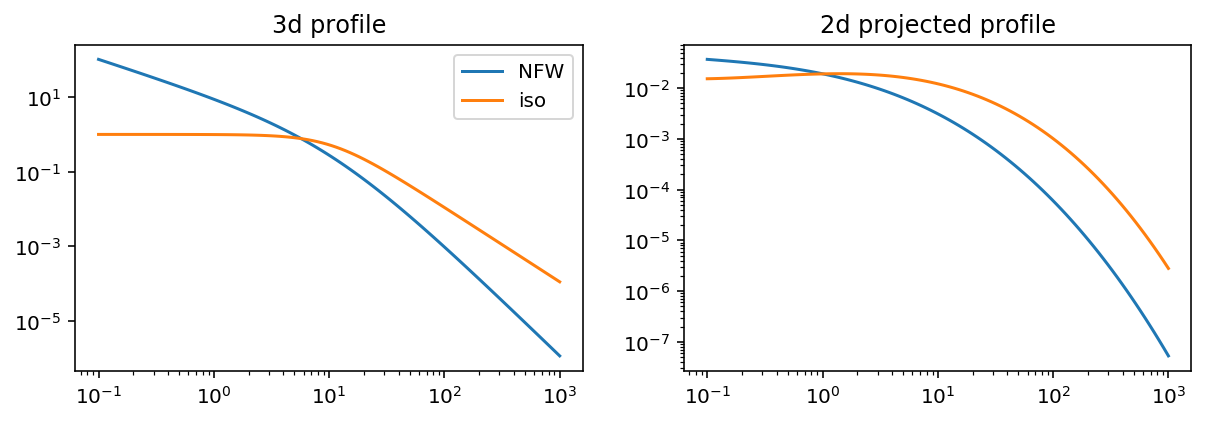

In [2]:
from cosmo_tools import *

fig, ax = plt.subplots(1,2,figsize=(10,3))
for profile_name in ['NFW','iso']:
    r_arr = np.logspace(-1,3,100)
    DMprof = halo_proile(profile_name)
    p2d_arr = DMprof.profile_2d(r_arr, 0.5, 1e13)
    p3d_arr = DMprof.profile_3d(r_arr, 0.5, 1e13)
    ax[0].loglog(r_arr,p3d_arr,label=profile_name)
    ax[1].loglog(r_arr,p2d_arr,label=profile_name)
ax[0].set_title('3d profile')
ax[1].set_title('2d projected profile')
ax[0].legend()